# Enriching Companies House data

![title](Images/ch_screenshot.png)

This notebook gives an overview on how business data from Companies House is imported, formatting and then enriched by exploiting various APIs and websites. Examples of applications include:
-  Retrieving official company websites using Google Places API
-  Scraping websites to get keywords to classify the industry of businesses.
-  Obtaining social media accounts and handles for companies and then use these to get a proxy for their web presence (number of followers, likes etc.)

## Importing data

The Free Company Data Product is a downloadable data snapshot containing basic company data of live companies on the Companies House register, and is the principal dataset for this project. This is updated monthly and needs to be downloaded before importing as a pandas dataframe. First, we need to import some modules...

### Modules

-  Pandas: provide easy-to-use data structures in Python
-  Numpy: provides fast and efficient multidimensional arrays, in addition to linear algebra and mathematical operations.
-  Matplotlib: provides plot to visualise data

In [137]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib.pyplot as plt
# Increase figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

### Loading and formatting Companies House dataset

The latest version of the Free Company Data Product can be downloaded here. http://download.companieshouse.gov.uk/en_output.html. The zip file that is downloaded is approximately 300MB, and the raw CSV file around 2GB. Once downloaded, ensure that the data is saved in the root folder of this notebook (or amend directory as required).

In [7]:
# to-do: investigate warning on mixed data types
ch_raw = pd.read_csv('/Users/dataexploitationmac1/Desktop/Faisal/Datasets/BasicCompanyDataAsOneFile-2018-02-01.csv')
# ch_raw = pd.read_csv('/Users/fasamin/Desktop/DS/Datasets/BasicCompanyDataAsOneFile-2018-02-01.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# preview the data
ch_raw.head(10) # first 10 rows 

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,! LTD,08209948,NaN,NaN,METROHOUSE 57 PEPPER ROAD,HUNSLET,LEEDS,YORKSHIRE,NaN,LS10 2RU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/09/2019,11/09/2017
1,!BIG IMPACT GRAPHICS LIMITED,07382019,NaN,NaN,335 ROSDEN HOUSE,372 OLD STREET,LONDON,NaN,NaN,EC1V 9AV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05/10/2019,21/09/2016
2,!NNOV8 LIMITED,11006939,NaN,NaN,C/O FRANK HIRTH 1ST FLOOR,236 GRAY'S INN ROAD,LONDON,NaN,UNITED KINGDOM,WC1X 8HB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24/10/2019,NaN
3,!NSPIRED LTD,SC421617,NaN,NaN,26 POLMUIR ROAD,NaN,ABERDEEN,NaN,UNITED KINGDOM,AB11 7SY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/04/2020,11/04/2017
4,!NVERTD DESIGNS LIMITED,09152972,NaN,NaN,55A HIGH STREET,NaN,SILSOE,BEDFORDSHIRE,NaN,MK45 4EW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/08/2020,30/07/2017
5,!OBAC LIMITED,FC031362,NaN,NaN,1ST AND 2ND FLOORS ELIZABETH HOUSE,LES RUETIES BRAYES,ST PETER PORT,GUERNSEY,GUERNSEY,GY1 1EW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,!OBAC UK LIMITED,07687209,NaN,NaN,ENDEAVOUR HOUSE,COOPERS END ROAD,STANSTED AIRPORT,NaN,NaN,CM24 1SJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/07/2020,29/06/2017
7,!YOZO FASS LIMITED,02714021,NaN,NaN,1 VERONICA HOUSE,WICKHAM ROAD,BROCKLEY,NaN,NaN,SE4 1NQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26/05/2020,12/05/2017
8,""" BROOK VIEW ""MECHANICAL AND ELECTRICAL ENGINE...",10275228,NaN,NaN,62 STAKES ROAD,PURBROOK,WATERLOOVILLE,HAMPSHIRE,ENGLAND,PO7 5NT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/07/2020,11/07/2017
9,"""1 C O LIMITED""",03811958,NaN,NaN,FANE COURT,GREEN ROAD SHIPBOURNE,TONBRIDGE,KENT,NaN,TN11 9PL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05/08/2020,22/07/2017


In [9]:
# fields available
ch_raw.columns

Index(['CompanyName', ' CompanyNumber', 'RegAddress.CareOf',
       'RegAddress.POBox', 'RegAddress.AddressLine1',
       ' RegAddress.AddressLine2', 'RegAddress.PostTown', 'RegAddress.County',
       'RegAddress.Country', 'RegAddress.PostCode', 'CompanyCategory',
       'CompanyStatus', 'CountryOfOrigin', 'DissolutionDate',
       'IncorporationDate', 'Accounts.AccountRefDay',
       'Accounts.AccountRefMonth', 'Accounts.NextDueDate',
       'Accounts.LastMadeUpDate', 'Accounts.AccountCategory',
       'Returns.NextDueDate', 'Returns.LastMadeUpDate',
       'Mortgages.NumMortCharges', 'Mortgages.NumMortOutstanding',
       'Mortgages.NumMortPartSatisfied', 'Mortgages.NumMortSatisfied',
       'SICCode.SicText_1', 'SICCode.SicText_2', 'SICCode.SicText_3',
       'SICCode.SicText_4', 'LimitedPartnerships.NumGenPartners',
       'LimitedPartnerships.NumLimPartners', 'URI', 'PreviousName_1.CONDATE',
       ' PreviousName_1.CompanyName', ' PreviousName_2.CONDATE',
       ' PreviousName_2.C

In [10]:
# remove unnecessary columns for this project
# why is copy() used? See explanation at link below:
# https://stackoverflow.com/questions/27673231/why-should-i-make-a-copy-of-a-data-frame-in-pandas
ch = ch_raw.iloc[:,[0,1,4,5,6,7,8,9,10,11,12,18,19,21,26,27,28,29]].copy()

# rename columns
ch.columns = ['name','crn','address1','address2','postTown','county','country', \
            'postcode','category','status','origin','accounts_lastMadeUpDate','accountCategory',\
            'returns_lastMadeUpDate','sic1','sic2','sic3','sic4']

In [11]:
# format missing values
ch.sic1.replace('None Supplied', np.NaN, inplace=True)
ch = ch.dropna(subset=['name']) # delete rows with null business names (usually only a few values)

In [12]:
# Produce a range of key stats 
# Key stats
print('---------')
print('Number of businesses: %s' %len(ch))
print('Missing SIC codes: %s' %ch.sic1.isnull().sum())
sic_comp = (1.0 - (float(ch.sic1.isnull().sum())/len(ch)))*100
print('SIC code completion: %.2f' %sic_comp + '%')
post_comp = (1.0 - (float(ch.postcode.isnull().sum())/len(ch)))*100
print('Postcode completion: %.2f' %post_comp + '%')
print('---------')
print('Category breakdown (top 5)')
print('')
print(ch.category.value_counts().head())
print('---------')
print('Account category (top 5)')
print('')
print(ch.accountCategory.value_counts().head())
print('---------')
print('Geographical breakdown (top 5)')
print('')
print(ch.origin.value_counts().head())
print('---------')
print('SIC code breakdown (top 5)')
print('')
print(ch.sic1.value_counts().head())

---------
Number of businesses: 4141304
Missing SIC codes: 164365
SIC code completion: 96.03%
Postcode completion: 98.73%
---------
Category breakdown (top 5)

Private Limited Company                                                                      3836722
PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)                          93700
Limited Liability Partnership                                                                  53947
Limited Partnership                                                                            47907
PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)      42220
Name: category, dtype: int64
---------
Account category (top 5)

NO ACCOUNTS FILED        1092147
TOTAL EXEMPTION FULL      748926
TOTAL EXEMPTION SMALL     671944
DORMANT                   507577
FULL                      116793
Name: accountCategory, dtype: int64
---------
Geographical breakdown (top 5)

United Kingdom     4129921


### Data exploration

Some pandas commands to explore the dataset, including setting up a function to find companies.

In [ ]:
ch.dtypes # types of each column - all objects

In [ ]:
def find_company(name):
    '''
    Searches companies house dataset for company name which include the given input which must be a string.
    '''
    name = name.lower()
    n = ch.name.str.lower().str.contains(name)
    x = input(str(n.sum()) + ' companies found. See list of companies? Y or N? ')
    if x.lower() == 'y':
        return ch[n]
    else:
        return True

In [ ]:
find_company('Burberry') # testing function on a few cases 

In [ ]:
find_company('Dyson')

Exploring SIC codes...

In [ ]:
ch.sic1.describe() # counts occurences and unique values

Sorting by the top 20 SIC codes shows that some of these are not very descriptive. Top of the list is 'Other business support service activities n.e.c'. Third is 'Dormant Company' and this is followed by 'Other service activities n.e.c'.

In [ ]:
ch.sic1.value_counts().head(20) # sort by top 20 sic codes

In [ ]:
ch.sic1.value_counts().head(30).plot() # shows skew of top categories
plt.show()

Checking if company reference numbers are unique

In [ ]:
ch.crn.describe() # all crns are unique

In [ ]:
ch.crn.isnull().sum() # 0

Exploring the address data

In [ ]:
ch.head() # reminder of the address fields

In [ ]:
ch.address1.describe() # 1.6 million unique address

In [ ]:
ch.address1.isnull().sum() # 27K null addresses

In [ ]:
ch.postTown.isnull().sum() # 93K missing town names

In [ ]:
ch.postcode.isnull().sum() # 52K missing post codes

### Export formatted dataset

In [13]:
# Export dataset, named after MMYY of ch data
ch.to_csv('ch_2018-02.csv',index=False)

Optional: remove non-UK companies 

In [ ]:
ch_uk = ch[ch['origin'].isin(['United Kingdom','Great Britain','UNITED KINGDOM','GREAT BRITAIN','ENGLAND & WALES','UK'])]
ch_uk.reset_index(inplace=True)
ch_uk.to_csv('ch_2018-02_uk.csv',index=False)

## Scraping data from Google Search Results

This section goes through the process of running google searches of business names in Companies House, scraping text from the results, and then returning a wordcloud of text from the first page of results.

The code below builds up the code for functions that run searches and produce
worldclouds as follows:

cloud(keyWords(search('Company Name')))

- search(string): returns a list of URLs from Google for the given term
- keyWords(list): screen-scrapes all visible text from the given list of URLs, and cleans
- cloud(string): after removing a given list of stopwords, produces a wordcloud

### Importing further modules and data

In [128]:
import webbrowser # to open web links
import nltk # natural language toolkit
from nltk.corpus import stopwords # Import the stop word list, may require download
# WordCloud modules
from wordcloud import WordCloud, STOPWORDS

import re # regular expressions 
from time import sleep # to pause web-scraper
import requests # allows you to send HTTP requests via Python
from bs4 import BeautifulSoup # beautiful soup for parsing of HTML

Read in formatted CH dataset if starting a new session. We'll refer to this at the end of the section after we've built up our tools to scrape and clean website text.

In [ ]:
ch = pd.read_csv('ch_2018-02.csv')

### Returning links for a Google Search term

First, we need to build some functionality to scrape the search results returned by Google.

In [ ]:
# Set business search term as an example
biz = 'DYSON LIMITED'

In [ ]:
# Read HTML
html = requests.get('https://www.google.co.uk/search?q='+ biz)
# Parse HTML into a BeautifulSoup object
soup = BeautifulSoup(html.content, 'html5lib')

In [ ]:
# Get all links and put into list
list_of_links = []
for link in soup.find_all('a'):
    list_of_links.append(link.get('href'))

In [ ]:
print(list_of_links) # needs cleaning up 

In [ ]:
# Cleaning up results
links = DataFrame({'urls':list_of_links}) #turn list into DF
links = links[links.urls.str.contains('/url?')] #Only search results

In [ ]:
# remove cached sites
links = links[links.urls.str.contains('webcache.googleusercontent') == False]

In [ ]:
# remove opening url?q= string
links = links.urls.str.replace('/url\?q=',"")
# after this, you don't need to call list anymore on the column

In [ ]:
# remove suffixed &sa bit by splitting and drop index
links = links.str.split('&sa',1).reset_index().drop('index',1)
# this is now a dataframe

In [ ]:
# use iterrows to grab first entry in each list which should be the working url
links_cleaned = []
for row in links.iterrows():
    links_cleaned.append(row[1][0][0])

In [ ]:
# convert to dataframe
links_cleaned = DataFrame(links_cleaned)

We can now bring this together in one function. Note that we're screen-scraping from Google Search results so we'll need to be careful to not overload Google with search requests in quick succession (and potentially get our IP blocked).

In [129]:
def search_google(business_name):
    '''
    Takes in a business name and returns the links returned in the first page of Google Search results
    '''
    # Read HTML
    html = requests.get('https://www.google.co.uk/search?q='+business_name)
    # Parse HTML into a BeautifulSoup object
    soup = BeautifulSoup(html.content, 'html5lib')

    # Get all links and put into list
    list_of_links = []
    for link in soup.find_all('a'):
        list_of_links.append(link.get('href'))

    # Cleaning up results
    links = DataFrame({'urls':list_of_links}) #turn list into DF
    links = links[links.urls.str.contains('/url?')] #Only search results
    
    # remove cached sites
    links = links[links.urls.str.contains('webcache.googleusercontent') == False]

    # remove opening url?q= string
    links = links.urls.str.replace('/url\?q=',"")
    # after this, you don't need to call list anymore on the column

    # remove suffixed &sa bit by splitting and drop index
    links = links.str.split('&sa',1).reset_index().drop('index',1)
    # this is now a dataframe

    # use iterrows to grab first entry in each list which should be the working url
    links_cleaned = []
    for row in links.iterrows():
        links_cleaned.append(row[1][0][0])
        
    # convert to dataframe
    links_cleaned = DataFrame(links_cleaned)

    return links_cleaned[0]

In [ ]:
burberry_links = search_google('burberry limited')

In [ ]:
# use webbrowser library to open all links in browser (if needed)
for link in burberry_links:
    webbrowser.open(link)

### Extract key text from company websites 

Now that we've got the functionality to return links from Google search results, we want to navigate to each link, scrape and format the text to find words with explanatory value after removing stopwords and other standard website text. Let's use the Dyson website as an example. 

In [ ]:
dyson_links = search_google('Dyson Limited')

In [ ]:
# Inspecting the first search result
# Read HTML
html = requests.get(dyson_links[0])
# Parse HTML into a BeautifulSoup object
soup = BeautifulSoup(html.content, 'html5lib')

In [ ]:
# Extracting text from key html sections
[s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]

In [ ]:
# Get all visible text
text = soup.getText().encode('ascii','ignore')

We want to clean up this text by removing HTML tags and new line indicators. 

In [ ]:
text_r = str(text).replace('\\n','').replace('\\t','').replace('\\r','')
print(text_r)

In [130]:
def stripsymbols(text):
    '''
    Use regular expressions to do a find-and-replace of HTML text.
    Function found online
    '''
    text = str(text)
    x = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text)
    x = re.sub('/(^|\b)@\S*($|\b)/'," ",x)
    x = re.sub('/(^|\b)#\S*($|\b)/'," ",x)
    x = re.sub("[^a-zA-Z]"," ",x)
    x = re.sub(r"(?:\@|https?\://)\S+", " ",x)
    return x

In [ ]:
text_stripped = stripsymbols(text_r)
print(text_stripped)

Getting better! The final step is remove stop words by invoking the Natural Language Toolkit Library we imported earlier. Let's see what kind of stop words are classified in the library. 

In [ ]:
print(stopwords.words('English'))

We can create a function to remove stopwords from website text.

In [131]:
def removeStopWords(text):
    '''
    Remove stopwords from given text string
    '''
    words = [w for w in text if not w in stopwords.words("english")]
    return words

In [ ]:
# Prepare text for function by (a) changing to lowercase (2) remove whitespace from beginning and end 
# (3) splitting the text to create a list of individual wordsvisible_text_stripped.lower().strip().split() 
text_stripped_split = text_stripped.lower().strip().split()
text_stripped_split

Finally, running this through the removeStopWords function gives us something in a much better shape than the original text. 

In [ ]:
text_cleaned = removeStopWords(text_stripped_split)
text_cleaned

Wrapping this all up into a function...

In [132]:
def cleantext(text):
    text_r = str(text).replace('\\n','').replace('\\t','').replace('\\r','')
    text_stripped = stripsymbols(text_r)
    text_stripped_split = text_stripped.lower().strip().split()
    text_cleaned = removeStopWords(text_stripped_split)
    return ' '.join(text_cleaned) # returns a joined list of the remaining words 

In [ ]:
dyson_cleaned = cleantext(text) # example of a function
dyson_cleaned

### Using the Natural Language Toolkit to tokenise and tag words

Another feature of the Natural Language Toolkit we can exploit is the ability to tag words and categorise them into their 'parts of speech' (i.e. nouns, verbs, adverbs). Perhaps this can be used to tag words from the scraped text, and retrieve nouns under the assumption that they provide the greatest explanatory power.

Let's test this with the scraped text from the previous section.

In [ ]:
dyson_cleaned

In [ ]:
tokens = nltk.word_tokenize(dyson_cleaned) # tokenize (split) the string
print(tokens)

The tags bellow are given according to the Penn Treebank Project here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

The results are quite interesting. Words like 'vacuums', 'cylinders', 'robot' and 'dryers' are correctly given as nouns. However, some words are double-tagged. For instance, 'dyson' is given as a verb as well as a noun. 'Airblade' is given as a past-tense verb. 

From this example alone, filtering on nouns would yield the best results.

In [ ]:
tagged = nltk.pos_tag(tokens) # categorise words according to their parts of speech
print(tagged)

In [ ]:
# Keep nouns only
tagged_nouns = " ".join([word[0] for word in tagged if word[1] in ['NNS','NN']])
tagged_nouns

In [ ]:
# Difference in list sizes - 1,352 removed words (out of 3,767)
len(dyson_cleaned) - len(tagged_nouns)

### Master function and wordclouds

Let's collect everything we've built in Section 2 and build our final master functions.

In [133]:
def key_words(list_of_urls):
    '''
    From the given list of urls, this function scrapes, cleans (removing symbols and non-nouns)
    and gathers all text into a single string
    '''
    
    words_cleaned = '' # Set up empty string
    
    for website in list_of_urls:
        # try / except for troublesome websites
        try:
            html = requests.get(website)
            soup = BeautifulSoup(html.content, 'html5lib')
            [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
            visibleText = soup.getText().encode('ascii','ignore')
            words_cleaned += cleantext(visibleText) # Calling the function we built earlier 
        except:
            continue
            
    # Tokenize and tag words
    tokens = nltk.word_tokenize(words_cleaned)
    tagged = nltk.pos_tag(tokens)

    # Keep nouns only
    keywords = " ".join([word[0] for word in tagged if word[1] in ['NNS','NN']])
    return keywords

In [ ]:
key_words(search_google('Dyson Limited')) # testing on an example - takes a few seconds to run

This is best visualised in a word cloud...

In [134]:
def cloud(words):
    '''
    Function that takes in a string and produces a word cloud
    '''
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400
                         ).generate(words)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    return wordcloud

In [ ]:
cloud(key_words(search_google('Royal Dutch Shell'))) # can take upto a minute to run

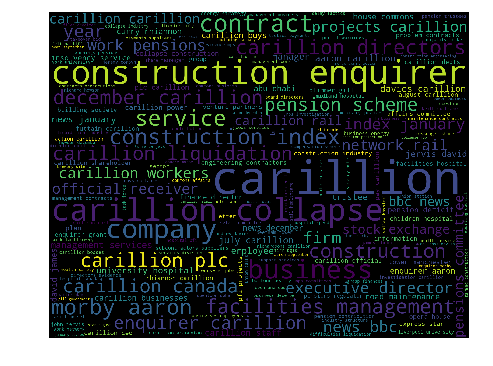

In [138]:
x = cloud(key_words(search_google('carillion')))

There is a lot of scope to improve this. Certain terms from websites that commonly re-occur can be filtered out by updating the stopwords set as follows.

In [ ]:
# ways to improve this: list of common names, weights and quantities, months and dates,

custom_words = ['sun','new','showbiz','tv','uk','john','lewis','partnership','offers','store',
'business','company','stores','shop','department','partner','street','london','partners','peter',
'jones','duration', 'views', 'minutes', 'month', 'version', 'system','tesco','september','privacy',
'policy','customer','service','home', 'company', 'london', 'price', 'offer', 'customer',
'service', 'home', 'year', 'london', 'day', 'march', 'business', 'shop','item','level','logo','menu',
'account','co','road','centre']


#STOPWORDS is a set, so need to use update method
STOPWORDS.update(custom_words)

## Connecting to Google Places API

We've relied on Google Search results to hopefully get websites that relate to a company term. However, the Google Places API can be linked to with a company's name and postcode and used to retrieve the company website and other details. 

Information from Google Places is displayed for certain businesses and places of interest as shown below.

![title](Images/google_places_screenshot.png)

### Modules and setup

We begin as usual by importing the required modules

In [60]:
import pandas as pd
import numpy as np
import requests
from time import sleep # to pause requests when web-scraping

Google Places API requests can be called with the requests package. By default, you'll be able to send 1,000 requests per day but this can be increased free of charge, up to 150,000 requests per 24 hour period, by enabling billing on the Google API Console to verify your identity. Check quota here (after registering): http://code.google.com/apis/console

In [45]:
YOUR_API_KEY = '' # enter API key which you'll receive from Google 

Check documentation here for info on the various Google Places APIs: https://developers.google.com/places/web-service/

Let's use the postcode for London Eye as an example: SE1 7PB. We'll need to input the longitude and latitude for this

In [113]:
postcode = 'SE1 7PB'

In [114]:
html = requests.get("http://api.postcodes.io/postcodes/" + postcode)
html.json()

{'result': {'admin_county': None,
  'admin_district': 'Lambeth',
  'admin_ward': "Bishop's",
  'ccg': 'NHS Lambeth',
  'codes': {'admin_county': 'E99999999',
   'admin_district': 'E09000022',
   'admin_ward': 'E05000416',
   'ccg': 'E38000092',
   'nuts': 'UKI45',
   'parish': 'E43000212',
   'parliamentary_constituency': 'E14001008'},
  'country': 'England',
  'eastings': 530635,
  'european_electoral_region': 'London',
  'incode': '7PB',
  'latitude': 51.5028202620979,
  'longitude': -0.119252376858172,
  'lsoa': 'Lambeth 036A',
  'msoa': 'Lambeth 036',
  'nhs_ha': 'London',
  'northings': 179886,
  'nuts': 'Lambeth',
  'outcode': 'SE1',
  'parish': 'Lambeth, unparished area',
  'parliamentary_constituency': 'Vauxhall',
  'postcode': 'SE1 7PB',
  'primary_care_trust': 'Lambeth',
  'quality': 1,
  'region': 'London'},
 'status': 200}

In [115]:
lat = html.json()['result']['latitude']
lon = html.json()['result']['longitude']
lat, lon

(51.5028202620979, -0.119252376858172)

### Nearby search

A Nearby Search lets you search for places within a specified area. You can refine your search request by supplying keywords or specifying the type of place you are searching for. A nearby search request is an HTML URL of the following form:

https://maps.googleapis.com/maps/api/place/nearbysearch/json?location=-33.8670522,151.1957362&radius=500&type=restaurant&keyword=cruise&key=YOUR_API_KEY

Using the London Eye as an example:

In [116]:
london_eye = requests.get('https://maps.googleapis.com/maps/api/place/nearbysearch/json?location=' + \
                          str(lat) + ',' + str(lon)  + '&' + 'keyword=London+Eye' + '&' + \
                          'rankby=distance' + '&' + \
                          'key=' + str(YOUR_API_KEY))
london_eye.json()

{'html_attributions': [],
 'results': [{'geometry': {'location': {'lat': 51.503324, 'lng': -0.119543},
    'viewport': {'northeast': {'lat': 51.50464877989272, 'lng': -0.11644895},
     'southwest': {'lat': 51.50194912010727, 'lng': -0.12057435}}},
   'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png',
   'id': '6d925b4f3e0d975eb6955a915a0689f8f4f0abd2',
   'name': 'Coca-Cola London Eye',
   'opening_hours': {'open_now': False, 'weekday_text': []},
   'photos': [{'height': 1357,
     'html_attributions': ['<a href="https://maps.google.com/maps/contrib/116005689309535848009/photos">Frederic Dossin</a>'],
     'photo_reference': 'CmRaAAAArwbW68jgU2_WNFnLTo8oK7fve0X0ikLnvGG4zVIu7vlqjmuZ2l-le3eF8tFpxf9YhJHqF74Q5PJTqtAHUFFXN2bxkpYWlwMNxSUUUgSFhNsYIP50jA2BVfZzdn1tKYWnEhBcOz6WgJtzABWFhDDNZj0aGhSQxfZLxb23ct9GKS9GFc_YiOqf2w',
     'width': 2048}],
   'place_id': 'ChIJc2nSALkEdkgRkuoJJBfzkUI',
   'rating': 4.4,
   'reference': 'CmRbAAAABcoDdammYEIy6hwNfXqyU4HAh5w

Exploring the json() file...

In [117]:
london_eye.json()['results'] # list of results


[{'geometry': {'location': {'lat': 51.503324, 'lng': -0.119543},
   'viewport': {'northeast': {'lat': 51.50464877989272, 'lng': -0.11644895},
    'southwest': {'lat': 51.50194912010727, 'lng': -0.12057435}}},
  'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png',
  'id': '6d925b4f3e0d975eb6955a915a0689f8f4f0abd2',
  'name': 'Coca-Cola London Eye',
  'opening_hours': {'open_now': False, 'weekday_text': []},
  'photos': [{'height': 1357,
    'html_attributions': ['<a href="https://maps.google.com/maps/contrib/116005689309535848009/photos">Frederic Dossin</a>'],
    'photo_reference': 'CmRaAAAArwbW68jgU2_WNFnLTo8oK7fve0X0ikLnvGG4zVIu7vlqjmuZ2l-le3eF8tFpxf9YhJHqF74Q5PJTqtAHUFFXN2bxkpYWlwMNxSUUUgSFhNsYIP50jA2BVfZzdn1tKYWnEhBcOz6WgJtzABWFhDDNZj0aGhSQxfZLxb23ct9GKS9GFc_YiOqf2w',
    'width': 2048}],
  'place_id': 'ChIJc2nSALkEdkgRkuoJJBfzkUI',
  'rating': 4.4,
  'reference': 'CmRbAAAABcoDdammYEIy6hwNfXqyU4HAh5weyw2l1RPZTBQ-KT54IkUt9Gup7pHKMAJU0qfMszEOOxv5CHstTt

In [118]:
london_eye.json()['results'][0]['name'] # name of place

'Coca-Cola London Eye'

In [119]:
le_id = london_eye.json()['results'][0]['place_id'] # id of location 
le_id

'ChIJc2nSALkEdkgRkuoJJBfzkUI'

Now that we've got the id, we can get the website from the text search API.

Before leaving this section, let's build a helper function that returns the location id from a given set of parameters. We'll need to call upon this function later.

In [61]:
def nearby_search(lat,lon,keyword,api_key):
    '''
    input: latitude and longitude (floats), api_key for Google Places (string)
    output: location_id of place closest to co-ordinates and that matches the keyword
    if the company is not found, then a message will be given
    '''
    
    # feed parameters to html 
    html = requests.get('https://maps.googleapis.com/maps/api/place/nearbysearch/json?location=' + \
                        str(lat) + ',' + str(lon)  + '&' + 'keyword=' + keyword + '&' + \
                        'rankby=distance' + '&' + 'key=' + str(api_key))
        
    # Error message if location not found
    try: 
        place_id = html.json()['results'][0]['place_id']
    
    except:
        return 'Location not found'
    
    # return entire json for testing
    # return html.json()
    
    return place_id

In [ ]:
# testing the function
nearby_search(51.5028202620979,-0.119252376858172,'London Eye',YOUR_API_KEY) # correct

In [ ]:
# Returns a KFC about 1 mile from the London Eye. Since we can't restrict radius with the rankby parameter, 
# depending on how strict the business name matching is, we run the risk of mismatches
nearby_search(51.5028202620979,-0.119252376858172,'KFC',YOUR_API_KEY)

In [ ]:
nearby_search(51.5028202620979,-0.119252376858172,'London',YOUR_API_KEY) # returns 'London' - the entire city?

In [ ]:
nearby_search(51.5028202620979,-0.119252376858172,'Eye',YOUR_API_KEY) # Specsavers in the Strand

In [ ]:
nearby_search(51.5028202620979,-0.119252376858172,'Wheel',YOUR_API_KEY) # Kwik-fit in Elephant & Castle

In [ ]:
nearby_search(51.5028202620979,-0.119252376858172,'Ferris Wheel',YOUR_API_KEY) # Correct - London Eye

In [ ]:
nearby_search(50.547036619931,-3.49639521511686,'R.B.W. DEVELOPMENTS LTD.',YOUR_API_KEY) # Testing sample

In [52]:
place_search(nearby_search(54.288992488345,-1.59221709336977,'North Yorkshire Business Systems Ltd',YOUR_API_KEY))

'http://www.northyorkshirewebsites.com/'

### Place search

Link here: https://developers.google.com/places/web-service/details

Once you have a place_id from a Place Search, you can request more details about a particular establishment or point of interest by initiating a Place Details request. A Place Details request returns more comprehensive information about the indicated place such as its complete address, phone number, user rating and reviews. A Place Details request is an HTTP URL of the following form:

In [120]:
https://maps.googleapis.com/maps/api/place/details/output?parameters

SyntaxError: invalid syntax (<ipython-input-120-3465eb100c77>, line 1)

Calling this on the London Eye place id..

In [121]:
london_eye_website = requests.get('https://maps.googleapis.com/maps/api/place/details/json?' + \
                    'placeid=' + le_id + '&' + 'key=' + str(YOUR_API_KEY))

In [140]:
london_eye_website.json()['result'] # list of results

{'address_components': [{'long_name': 'London',
   'short_name': 'London',
   'types': ['postal_town']},
  {'long_name': 'Lambeth',
   'short_name': 'Lambeth',
   'types': ['neighborhood', 'political']},
  {'long_name': 'Greater London',
   'short_name': 'Greater London',
   'types': ['administrative_area_level_2', 'political']},
  {'long_name': 'United Kingdom',
   'short_name': 'GB',
   'types': ['country', 'political']},
  {'long_name': 'SE1 7PB', 'short_name': 'SE1 7PB', 'types': ['postal_code']}],
 'adr_address': '<span class="locality">London</span> <span class="postal-code">SE1 7PB</span>, <span class="country-name">UK</span>',
 'formatted_address': 'Lambeth, London SE1 7PB, UK',
 'formatted_phone_number': '0870 990 8881',
 'geometry': {'location': {'lat': 51.503324, 'lng': -0.119543},
  'viewport': {'northeast': {'lat': 51.5046479302915, 'lng': -0.11644895},
   'southwest': {'lat': 51.50194996970851, 'lng': -0.1205743500000001}}},
 'icon': 'https://maps.gstatic.com/mapfiles/pla

In [ ]:
london_eye_website.json()['result']['formatted_address']

In [123]:
london_eye_website.json()['result']['international_phone_number']

'+44 870 990 8881'

In [ ]:
london_eye_website.json()['result']['opening_hours'] # dictionary of opening hours

In [ ]:
london_eye_website.json()['result']['reviews'] # reviews

In [142]:
london_eye_website.json()['result']['reviews'] # example of a review - NLP potential

[{'author_name': 'Carol Allen',
  'author_url': 'https://www.google.com/maps/contrib/105769404530673577514/reviews',
  'language': 'en',
  'profile_photo_url': 'https://lh5.googleusercontent.com/-Hywar_OnX30/AAAAAAAAAAI/AAAAAAAAAAA/ACSILjVjoabDgPYhgi77r7FJb9f3Gq-q3Q/s128-c0x00000000-cc-rp-mo-ba3/photo.jpg',
  'rating': 5,
  'relative_time_description': 'in the last week',
  'text': 'What an experience.  The staff were very efficient and friendly and although the queues were long we did not have to wait long.  Elderly and disabled people were assisted and given preferential treatment which was good to see.  The security and maintenance teams really impressed me and I felt extremely safe in my bubble. Stunning views and photos to treasure our memories were made available shortly after.  A great overall experience.  Thank you',
  'time': 1519061460},
 {'author_name': 'Javeed Islam',
  'author_url': 'https://www.google.com/maps/contrib/100305070980005337396/reviews',
  'language': 'en',
  

In [ ]:
london_eye_website.json()['result']['website'] # place website

As before, let's build a helper function for convenience in the following section

In [62]:
def place_search(place_id):
    '''
    input: place_id from Nearby Search API (string)
    output: company website (if found)
    If a website is not found, then an error message will be given
    '''
    
    # exception in case place_id doesn't yield results in Place Search
    try:
        html = requests.get('https://maps.googleapis.com/maps/api/place/details/json?' + \
                    'placeid=' + place_id + '&' + 'key=' + str(YOUR_API_KEY))
    except:
        return 'No results in Place Search'
    
    # exception if website is not found
    try:
        website = html.json()['result']['website']
    except:
        return 'Website not found'
    
    return website

In [ ]:
# Testing function with London Eye ID
place_search('ChIJc2nSALkEdkgRkuoJJBfzkUI')

In [ ]:
# Testing function with other IDs
place_search('ChIJmbKqQlgDdkgRfkx7-tWdNU4') # KFC in Lambeth - not branch-specific

In [ ]:
place_search('ChIJdd4hrwug2EcRmSrV3Vo6llI') # for London - website not avaiable

In [ ]:
place_search('ChIJDYZYNsoEdkgRHCQ30Uysy_M') # Specsavers - branch-specific

In [ ]:
place_search('ChIJWwBL554EdkgRluPLRtvCKek') # Kwik-fit - branch specific

### Function to return website from given companies house details

Let's bring some of the pieces in the previous sections together to build a function that returns the company website (if found) from details found in the publicly-available Companies House dataset.

In Section 1.4, we exported a cleaned-up dataset of Companies House to a local directly. Let's import this now.

In [14]:
ch = pd.read_csv('ch_2018-02.csv')

In [15]:
ch.shape

(4141304, 18)

We'll be running the business name and the postcode through the Google Places API. The business name should be given but we'll need to exclude those records where the postcode is not given.

In [16]:
ch_w_pc = ch[ch.postcode.notnull()].copy()
ch_w_pc.shape

(4088872, 18)

Ok, so we've got our dataset. Let's now put our function together.

In [105]:
def return_website(company_name,postcode):
    '''
    Input: company name and postcode (both strings)
    Output: Company website
    '''
    
    # Step 1: Convert postcodes to latitude and longitude using postcodes.io
    # Some companies may give invalid postcodes in Companies House so build exception
    
    try: 
        html = requests.get("http://api.postcodes.io/postcodes/" + postcode)
        lat = html.json()['result']['latitude']
        lon = html.json()['result']['longitude']
    except:
        return 'Postcode not found'
    
    # Step 2: Get place_id by calling upon a Nearby Search (see Section 3.2)
    place_id = nearby_search(lat,lon,company_name,YOUR_API_KEY)
    
    # Step 3: Return website by feeding place_id into Place Search
    website = place_search(place_id)
    
    return website    

### Testing function on Companies House

Now for the fun stuff: let's test this function on a sample of companies in Companies House and see how many companies we get websites for.

In [64]:
# Random sample of a 100 companies from those entries with a postcode, only return name and postcode
ch_random_100 = ch_w_pc.sample(100)[['name','postcode']].copy()

In [65]:
ch_random_100.loc['website'] = np.NAN # set up blank column
ch_random_100

,name,postcode
3392553,SMART RETAIL SOLUTIONS LTD,SM4 5RR
3006422,QUANTUM ENGINEERING SOLUTIONS LIMITED,HU13 0EG
386534,AZTEQ LIMITED,HP7 0PX
3122752,RICHMOND BUSINESS SOLUTIONS LIMITED,SW17 0NB
59902,95/97 SPENCER ROAD MANAGEMENT COMPANY LIMITED,BT47 6AE
3356039,SIMON GILLESPIE ASSOCIATES LTD,PR1 8HX
524741,BLU BAY LIMITED,G42 0QG
3752776,THOMPSON AUTOMOBILES LIMITED,BT1 3BG
1015341,DAVID C. SMITH ARCHITECTS LIMITED,WA15 9NB
2105059,KOMPRI PROJECTS LIMITED,SW1W 9SA


In [67]:
# Retrieve websites for each company with a for loop
i = 1
for index, row in ch_random_100.iterrows():
    ch_random_100.loc[index,'website'] = return_website(row[0],row[1])
    print(str(i) + ' - ' + str(row[0]) + ' - ' + str(row[1]) + ' - ' + str(row[2]))
    i += 1
    sleep(0.5)

1 - SMART RETAIL SOLUTIONS LTD - SM4 5RR - Website not found
2 - QUANTUM ENGINEERING SOLUTIONS LIMITED - HU13 0EG - Website not found
3 - AZTEQ LIMITED - HP7 0PX - http://www.azteq.com/
4 - RICHMOND BUSINESS SOLUTIONS LIMITED - SW17 0NB - Website not found
5 - 95/97 SPENCER ROAD MANAGEMENT COMPANY LIMITED - BT47 6AE - Website not found
6 - SIMON GILLESPIE ASSOCIATES LTD - PR1 8HX - http://www.simongillespie.co.uk/
7 - BLU BAY LIMITED - G42 0QG - Website not found
8 - THOMPSON AUTOMOBILES LIMITED - BT1 3BG - Website not found
9 - DAVID C. SMITH ARCHITECTS LIMITED - WA15 9NB - Website not found
10 - KOMPRI PROJECTS LIMITED - SW1W 9SA - Website not found
11 - FRAMLINGTON INNOVATIVE GROWTH TRUST PLC - EC1A 7NX - Website not found
12 - FORESIGHT REFRIGERATION LIMITED - BH24 3SE - Website not found
13 - DALCROSS HANDLING LIMITED - PH1 5JN - Website not found
14 - VISION ESTATE AGENTS LIMITED - W12 7LL - No results in Place Search
15 - DAVID NETWORKS L.P. - BT34 2BX - Website not found
16 - L

KeyboardInterrupt: 

In [ ]:
ch_random_100['website'].value_counts().head() # 17 websites out of 100 

In [ ]:
ch_random_100.to_csv('sample_of_100_websites.csv') # save results

Let's see if we can improve the match-rate by removing 'LTD. and 'LIMITED' from the end of the name

In [243]:
ch_random_100.loc[:,'website_2'] = np.NAN # set up blank column
ch_random_100

,name,postcode,website,website_2
3029309,R.B.W. DEVELOPMENTS LTD.,TQ14 8DP,Website not found,NaN
2670409,NOUVEAU'RA APPAREL LIMITED,UB4 0RA,Website not found,NaN
2475224,MIMI PARIS HOPPE LIMITED,RG27 9NN,Website not found,NaN
3008042,QUATRO HQ LIMITED,NG18 4FY,Website not found,NaN
965152,CW 10 PARK DRIVE LIMITED,E14 5AB,Website not found,NaN
2269669,LRW SUPPLIES LIMITED,LS12 3SS,Website not found,NaN
2968399,PROLOGUE MEDIA LIMITED,RG29 1PD,Website not found,NaN
976549,D J PALFREY SERVICES LTD,RM7 8AU,Website not found,NaN
3036941,RADIANT CLINICS LIMITED,L40 0SD,http://www.radiantskinclinic.co.uk/,NaN
977514,D M D BUILDING & ROOFING SERVICES LTD,NR2 4TW,Website not found,NaN


In [239]:
ch_random_100 = pd.read_csv('sample_of_100_websites.csv',index_col=0)

In [240]:
ch_random_100 = ch_random_100.head(100).copy()

In [246]:
ch_random_100

,name,postcode,website,website_2
3029309,R.B.W. DEVELOPMENTS LTD.,TQ14 8DP,Website not found,NaN
2670409,NOUVEAU'RA APPAREL LIMITED,UB4 0RA,Website not found,NaN
2475224,MIMI PARIS HOPPE LIMITED,RG27 9NN,Website not found,NaN
3008042,QUATRO HQ LIMITED,NG18 4FY,Website not found,NaN
965152,CW 10 PARK DRIVE LIMITED,E14 5AB,Website not found,NaN
2269669,LRW SUPPLIES LIMITED,LS12 3SS,Website not found,NaN
2968399,PROLOGUE MEDIA LIMITED,RG29 1PD,Website not found,NaN
976549,D J PALFREY SERVICES LTD,RM7 8AU,Website not found,NaN
3036941,RADIANT CLINICS LIMITED,L40 0SD,http://www.radiantskinclinic.co.uk/,NaN
977514,D M D BUILDING & ROOFING SERVICES LTD,NR2 4TW,Website not found,NaN


In [244]:
def standardise(company_name):
    stopwords = ['limited','ltd','ltd.','lp']
    querywords = str(company_name).split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    return result

In [248]:
ch_random_100['name_stripped'] = ch_random_100['name'].apply(standardise)

In [249]:
ch_random_100

,name,postcode,website,website_2,name_stripped
3029309,R.B.W. DEVELOPMENTS LTD.,TQ14 8DP,Website not found,NaN,R.B.W. DEVELOPMENTS
2670409,NOUVEAU'RA APPAREL LIMITED,UB4 0RA,Website not found,NaN,NOUVEAU'RA APPAREL
2475224,MIMI PARIS HOPPE LIMITED,RG27 9NN,Website not found,NaN,MIMI PARIS HOPPE
3008042,QUATRO HQ LIMITED,NG18 4FY,Website not found,NaN,QUATRO HQ
965152,CW 10 PARK DRIVE LIMITED,E14 5AB,Website not found,NaN,CW 10 PARK DRIVE
2269669,LRW SUPPLIES LIMITED,LS12 3SS,Website not found,NaN,LRW SUPPLIES
2968399,PROLOGUE MEDIA LIMITED,RG29 1PD,Website not found,NaN,PROLOGUE MEDIA
976549,D J PALFREY SERVICES LTD,RM7 8AU,Website not found,NaN,D J PALFREY SERVICES
3036941,RADIANT CLINICS LIMITED,L40 0SD,http://www.radiantskinclinic.co.uk/,NaN,RADIANT CLINICS
977514,D M D BUILDING & ROOFING SERVICES LTD,NR2 4TW,Website not found,NaN,D M D BUILDING & ROOFING SERVICES


In [259]:
# Retrieve websites for each company with a for loop
i = 1
for index, row in ch_random_100.iterrows():
    ch_random_100.loc[index,'website_2'] = return_website(row[4],row[1])
    print(str(i) + ' - ' + str(row[4]) + ' - ' + str(row[1]) + ' - ' + str(row[3]))
    i += 1
    sleep(0.5)

1 - R.B.W. DEVELOPMENTS - TQ14 8DP - Website not found
1 - NOUVEAU'RA APPAREL - UB4 0RA - Website not found
1 - MIMI PARIS HOPPE - RG27 9NN - Website not found
1 - QUATRO HQ - NG18 4FY - Website not found
1 - CW 10 PARK DRIVE - E14 5AB - Website not found
1 - LRW SUPPLIES - LS12 3SS - Website not found
1 - PROLOGUE MEDIA - RG29 1PD - Website not found
1 - D J PALFREY SERVICES - RM7 8AU - Website not found
1 - RADIANT CLINICS - L40 0SD - http://www.radiantliving.co.uk/
1 - D M D BUILDING & ROOFING SERVICES - NR2 4TW - Website not found
1 - BERKUT IMPEX - ML11 0QW - Website not found
1 - IT PROJECTIONS - LS3 1BQ - Website not found
1 - CNK CONSULTANCY - KT3 6DQ - Website not found
1 - BARKLEY ADVISORY - SG4 0TW - Website not found
1 - BUILDVALE - FK6 6QY - http://www.buildvale.co.uk/
1 - HENNIE PENNY'S CHICKEN (CLECKHEATON) - BD19 3TT - http://www.henniepennyschicken.co.uk/?utm_source=google&utm_medium=organic&utm_campaign=google%20places
1 - MIR POINT - SE2 9PJ - Website not found
1 - T

In [262]:
ch_random_100['website_2'].value_counts().head() # 18 websites out of 100, lose some cases, gain others

Website not found                 82
http://www.jte-castings.co.uk/     1
http://www.centralis.co.uk/        1
http://www.buildvale.co.uk/        1
http://johnfausset.co.uk/          1
Name: website_2, dtype: int64

In [261]:
ch_random_100.to_csv('sample_of_100_websites_2.csv') # save results

### Testing on NYER LEP

Import postcode lookups for the North Yorkshire and East Riding LEP from the National Postcode Lookup Table

In [4]:
nyer_postcodes = pd.read_csv('nyer_postcode.csv')

In [5]:
nyer_postcodes.head() # three postcodes to lookup for 

,POSTCODE,POSTCODE2,POSTCODE_PCDS,LAT,LONG,LEP1,LEP2,COUNTY_CODE,COUNTY_DIST_CODE,WARD_CODE
0,DL104AA,DL10 4AA,DL10 4AA,54.406898,-1.735670,E37000039,NaN,E10000023,E07000166,E05006292
1,DL104AB,DL10 4AB,DL10 4AB,54.406364,-1.734835,E37000039,NaN,E10000023,E07000166,E05006292
2,DL104AD,DL10 4AD,DL10 4AD,54.404175,-1.736544,E37000039,NaN,E10000023,E07000166,E05006292
3,DL104AE,DL10 4AE,DL10 4AE,54.404894,-1.736509,E37000039,NaN,E10000023,E07000166,E05006292
4,DL104AF,DL10 4AF,DL10 4AF,54.404665,-1.742795,E37000039,NaN,E10000023,E07000166,E05006294


Let's do an inner join from the CH data to the NYER postcodes on the POSTCODE_PCDS column.

In [37]:
ch_nyer = pd.merge(ch_w_pc, nyer_postcodes, how='inner', left_on='postcode', right_on='POSTCODE_PCDS')

In [38]:
ch_nyer.shape # 12,486 companies. Similiar to what we're seeing in CSAT.

(12486, 28)

In [57]:
ch_nyer.loc[:,'website'] = np.NAN # set up blank column
ch_nyer

,name,crn,address1,address2,postTown,county,country,postcode,category,status,...,POSTCODE2,POSTCODE_PCDS,LAT,LONG,LEP1,LEP2,COUNTY_CODE,COUNTY_DIST_CODE,WARD_CODE,website
0,"""STREONSHALH"" WHITBY LIMITED",01636551,"""STREONSHALH""",KHYBER PASS,WHITBY,NORTH YORKSHIRE,NaN,YO21 3DQ,"PRI/LTD BY GUAR/NSC (Private, limited by guara...",Active,...,YO21 3DQ,YO21 3DQ,54.488915,-0.615535,E37000039,NaN,E10000023,E07000168,E05006340,NaN
1,'OUT OF THIS WOLD' LTD,10553612,MILLHOLME FARM HOUSE,SPEETON STREET,FILEY,NaN,UNITED KINGDOM,YO14 9TG,Private Limited Company,Active,...,YO14 9TG,YO14 9TG,54.155893,-0.239788,E37000039,NaN,E10000023,E07000168,E05006327,NaN
2,CLIFF TOP LTD,04623454,"MILLHOLME FARM HOUSE, SPEETON",FILEY,YORKSHIRE,NaN,NaN,YO14 9TG,Private Limited Company,Active,...,YO14 9TG,YO14 9TG,54.155893,-0.239788,E37000039,NaN,E10000023,E07000168,E05006327,NaN
3,01722212 LIMITED,01722212,HILL VIEW HOUSE,"CORNBOROUGH ROAD, SHERIFF HUTTON",YORK,NORTH YORKSHIRE,NaN,YO60 6QJ,Private Limited Company,Active,...,YO60 6QJ,YO60 6QJ,54.091054,-1.009659,E37000039,NaN,E10000023,E07000167,E05006313,NaN
4,WORLD WIDE SHOPPING MALL LIMITED,03307834,HILL VIEW HOUSE,"CORNBOROUGH ROAD, SHERIFF HUTTON",YORK,NORTH YORKSHIRE,NaN,YO60 6QJ,Private Limited Company,Active,...,YO60 6QJ,YO60 6QJ,54.091054,-1.009659,E37000039,NaN,E10000023,E07000167,E05006313,NaN
5,01AA LIMITED,10017240,THE ROYAL HUNTING LODGE SHIPTON BY BENINGBROUGH,SHIPTON BY BENINGBROUGH,YORK,NORTH YORKS,UNITED KINGDOM,YO30 1BD,Private Limited Company,Active,...,YO30 1BD,YO30 1BD,54.051810,-1.166750,E37000039,NaN,E10000023,E07000164,E05009677,NaN
6,1 VOYAGE LIMITED,04683525,6 FEVERSHAM ROAD,NaN,HELMSLEY,NORTH YORKSHIRE,NaN,YO62 5HN,Private Limited Company,Active,...,YO62 5HN,YO62 5HN,54.250017,-1.058227,E37000039,NaN,E10000023,E07000167,E05006302,NaN
7,INSITE TRAINING & RESPONSE SOLUTIONS LIMITED,09132004,6 FEVERSHAM ROAD,NaN,HELMSLEY,NORTH YORKSHIRE,NaN,YO62 5HN,Private Limited Company,Active,...,YO62 5HN,YO62 5HN,54.250017,-1.058227,E37000039,NaN,E10000023,E07000167,E05006302,NaN
8,1-4 MUSEUM TERRACE (SCARBOROUGH) MANAGEMENT CO...,06759604,62-63 WESTBOROUGH,NaN,SCARBOROUGH,NORTH YORKSHIRE,NaN,YO11 1TS,Private Limited Company,Active,...,YO11 1TS,YO11 1TS,54.278977,-0.408069,E37000039,NaN,E10000023,E07000168,E05006317,NaN
9,15 ABERDEEN STREET FREEHOLD MANAGEMENT LIMITED,06629449,62 - 63 WESTBOROUGH,NaN,SCARBOROUGH,NORTH YORKSHIRE,NaN,YO11 1TS,Private Limited Company,Active,...,YO11 1TS,YO11 1TS,54.278977,-0.408069,E37000039,NaN,E10000023,E07000168,E05006317,NaN


In [106]:
# Retrieve websites for each company with a for loop
for index, row in ch_nyer.iterrows():
    if pd.notnull(row[28]) == True:
        continue
    ch_nyer.loc[index,'website'] = return_website(row[0],row[7]) 
    print(str(index) + ' - ' + str(row[0]) + ' - ' + str(row[7]) + ' - ' + str(ch_nyer.loc[index,'website']))
    sleep(0.2)

2300 - 4X4 ACCESSORIES & TYRES LIMITED - DL7 9UN - Postcode not found
2301 - 5 WINDSOR TERRACE (WHITBY) LIMITED - YO21 3DY - Website not found
2302 - DISCOVERY MINI BUS HIRE LTD - YO21 3DY - Website not found
2303 - MARK STRINGER BUILDING LIMITED - YO21 3DY - Website not found
2304 - 50 DEGREES NORTH LIMITED - DL10 5NY - Website not found
2305 - A2B TAXIS (NORTHALLERTON) LIMITED - DL10 5NY - Website not found
2306 - ACKLAM HALL ESTATES LIMITED - DL10 5NY - http://www.acklamhall.co.uk/
2307 - ACKLAM HALL MANAGEMENT LTD - DL10 5NY - http://www.acklamhall.co.uk/
2308 - ALDBROUGH ELECTRICAL AND TECHNICAL SERVICES LIMITED - DL10 5NY - Website not found
2309 - ALLAN RICHARDSON COMMERCIAL VEHICLE ENGINEERS LIMITED - DL10 5NY - Website not found
2310 - ALT BERG HOLDINGS LIMITED - DL10 5NY - http://www.altberg.co.uk/
2311 - APEX MEDICAL LOCUMS LIMITED - DL10 5NY - Website not found
2312 - ARB FOR TRAINING LIMITED - DL10 5NY - http://www.arbfortraining.com/
2313 - ARBURTON LIMITED - DL10 5NY - W

2417 - PLANET CITIZENS LIMITED - DL10 5NY - Website not found
2418 - POWER SYSTEM DESIGN SERVICES LIMITED - DL10 5NY - Website not found
2419 - PROJECT & PROGRAMME SERVICES LIMITED - DL10 5NY - http://mcluckieprojects.co.uk/
2420 - RA ORKNEY LIMITED - DL10 5NY - Website not found
2421 - RICHARDSON ELECTRICAL LIMITED - DL10 5NY - Website not found
2422 - RICHMOND SAFETY SERVICES LIMITED - DL10 5NY - Website not found
2423 - ROBERT H PEARSON ASSOCIATES LTD - DL10 5NY - Website not found
2424 - ROLANDWAY LIMITED - DL10 5NY - Website not found
2425 - RUBICON SOLUTIONS LIMITED - DL10 5NY - Website not found
2426 - RYBRLI LTD - DL10 5NY - Website not found
2427 - SOLUTIONS4LOGISITICS LIMITED - DL10 5NY - Website not found
2428 - SOUTHCROFT (FOREST) LIMITED - DL10 5NY - Website not found
2429 - SPELLMAN INTERIM SOLUTIONS LIMITED - DL10 5NY - Website not found
2430 - SPIV N SLIM LIMITED - DL10 5NY - Website not found
2431 - STERLING HR SOLUTIONS LIMITED - DL10 5NY - Website not found
2432 - ST

2538 - 57 SOUTH PARADE (NORTHALLERTON) MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2539 - ABBEY PARK (AMPLEFORTH) MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2540 - ADMINISTRATION SERVICES LIMITED - DL6 2NJ - Website not found
2541 - ALLERTON INDUSTRIES LIMITED - DL6 2NJ - http://www.allertonsteel.co.uk/
2542 - ALLERTON PROPERTY MANAGEMENT LTD. - DL6 2NJ - http://www.allertonpm.co.uk/
2543 - ASSOCIATION OF FENCING INDUSTRIES - DL6 2NJ - http://afiorg.uk/
2544 - ATHELSTANE CRESCENT MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2545 - BAG 2 SCHOOL LIMITED - DL6 2NJ - http://uk.bag2school.com/
2546 - BELLE VUE (DONCASTER) MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2547 - BURWOOD HEIGHTS MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2548 - CASTLEGATE & MOWBRAY PARK MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2549 - CATHEDRAL COURT MANAGEMENT COMPANY LIMITED - DL6 2NJ - Website not found
2550 - CENTURION FIELDS (ADEL

2647 - A & D PRECISION ENGINEERING NORTH YORKSHIRE LIMITED - YO13 9BD - Website not found
2648 - PBR ELECTRICAL LIMITED - YO13 9BD - Website not found
2649 - A & D STURDY LIMITED - YO17 8LH - Website not found
2650 - A & E HIGHWAY SERVICES LIMITED - DL6 3HA - https://www.hertz.co.uk/rentacar/reservation/
2651 - A & G DEVELOPMENTS (YORKSHIRE) LIMITED - DL10 6QH - https://www.hertz.co.uk/rentacar/reservation/
2652 - N J H ELECTRICAL ENGINEERING LIMITED - DL10 6QH - Website not found
2653 - A & H FREIGHT CONSULTANTS LTD - YO62 5YJ - https://www.hertz.co.uk/rentacar/reservation/
2654 - WIWOL AVIATION LTD - YO62 5YJ - Website not found
2655 - A & J STUBBS LIMITED - TS13 5ET - Website not found
2656 - A & M COMPANY SECRETARIAL SERVICES LTD - YO22 4DE - Website not found
2657 - ABBEY STEPS TEA ROOMS & GUEST HOUSE LIMITED - YO22 4DE - Website not found
2658 - ACCOUNTING & MANAGEMENT LIMITED - YO22 4DE - Website not found
2659 - BDS FLOORING SOLUTIONS LTD - YO22 4DE - Website not found
2660 - H

2763 - HOMEFINDER OF BRIDLINGTON LIMITED - YO12 5ET - Website not found
2764 - J & J DRIVING SERVICES LTD - YO12 5ET - Website not found
2765 - J D M  FREIGHT SERVICES LIMITED - YO12 5ET - Website not found
2766 - MICROGRAPHICS LTD - YO12 5ET - Website not found
2767 - MICROGRAPHICS UK LIMITED - YO12 5ET - Website not found
2768 - NIGEL PICKLES TRANSPORT LIMITED - YO12 5ET - Website not found
2769 - OATES, RIPLEY AND CO LIMITED - YO12 5ET - Website not found
2770 - ONE STOP BUSINESS TRAINING LIMITED - YO12 5ET - Website not found
2771 - PARADISE LEISURE (YORK) LIMITED - YO12 5ET - Website not found
2772 - PROPFIND YORKSHIRE LIMITED - YO12 5ET - Website not found
2773 - RING A LING LOGISTICS LIMITED - YO12 5ET - Website not found
2774 - T & A FLOORING LTD - YO12 5ET - Website not found
2775 - THE ORANGE TREE (ROSEDALE) LIMITED - YO12 5ET - http://www.thetree.earth/
2776 - VILLAGE ESTATES (TITANIC) LTD - YO12 5ET - Website not found
2777 - WILLING TRANSPORT LIMITED - YO12 5ET - Website n

2884 - EPWORTH HOTELS LIMITED - YO11 1JU - Website not found
2885 - EQUINE REPRODUCTIVE SERVICES (UK) LIMITED - YO11 1JU - http://www.equinereproductiveservices.co.uk/
2886 - EURASIA LAND DEVELOPMENT LTD - YO11 1JU - Website not found
2887 - EVENSTAR CONSULTING LIMITED - YO11 1JU - Website not found
2888 - FAIRHOLME FARMING LIMITED - YO11 1JU - Website not found
2889 - FCVH LIMITED - YO11 1JU - Website not found
2890 - FILEFONT LIMITED - YO11 1JU - Website not found
2891 - FOREST POULTRY LIMITED - YO11 1JU - Website not found
2892 - FYLING PARK MINERALS LIMITED - YO11 1JU - Website not found
2893 - FYLINGDALES MOOR ESS LIMITED - YO11 1JU - Website not found
2894 - G AND J CRABTREE LIMITED - YO11 1JU - Website not found
2895 - G&K SERVICES LIMITED - YO11 1JU - Website not found
2896 - GCD LIMITED - YO11 1JU - Website not found
2897 - GEORGE GREEN FARMS LIMITED - YO11 1JU - Website not found
2898 - GLOBAL TOURISM SOLUTIONS (UK) LIMITED - YO11 1JU - Website not found
2899 - GOLDEN SQUARE 

3005 - MAKERSMITH LIMITED - YO18 7AW - Website not found
3006 - MALTON OFFICE CENTRE LTD - YO18 7AW - http://www.maltonoffices.co.uk/
3007 - MALTON STORAGE LTD - YO18 7AW - http://www.yorkshireremovals-storage.co.uk/
3008 - MANOR GARDEN BUILDINGS LIMITED - YO18 7AW - Website not found
3009 - MARKETRY LIMITED - YO18 7AW - Website not found
3010 - MENTOR GUIDANCE LIMITED - YO18 7AW - Website not found
3011 - MGL HOMES LTD - YO18 7AW - Website not found
3012 - MILL FARM MINERALS LTD - YO18 7AW - Website not found
3013 - MO MO ARCHITECTURE LIMITED - YO18 7AW - Website not found
3014 - MONEYWEB 123 LIMITED - YO18 7AW - Website not found
3015 - MONEYWEB LIMITED - YO18 7AW - http://www.moneyweb-ifa.com/
3016 - NEIL STEAD LTD - YO18 7AW - Website not found
3017 - NEWBIGGIN HALL FARM LTD - YO18 7AW - http://www.newbigginhall.co.uk/
3018 - NEWBIGGIN HALL LTD - YO18 7AW - Website not found
3019 - NORTHFIELDS TURBINE LTD - YO18 7AW - Website not found
3020 - NORTON COURT PROPERTIES LIMITED - YO18 

3126 - SWINITHWAITE ESTATE SUPPLY COMPANY LIMITED - DL8 4UH - Website not found
3127 - WENSLEYDALE EXPERIENCE LIMITED - DL8 4UH - http://www.wensleydale.co.uk/
3128 - A.H. MUDD AGRICULTURAL SERVICES LIMITED - YO13 9DJ - Website not found
3129 - A.I.M.S.CONSTRUCTION LIMITED - YO60 7SD - Website not found
3130 - CYCLAIRE LTD - YO60 7SD - Website not found
3131 - DUNKELT LTD - YO60 7SD - Website not found
3132 - EXPERT PSYCHIATRIC SERVICES LIMITED - YO60 7SD - Website not found
3133 - LANSHORE INTERNATIONAL LTD - YO60 7SD - Website not found
3134 - LONETREE CARDS LTD - YO60 7SD - Website not found
3135 - RIDINGS CONSTRUCTION COMPANY LIMITED - YO60 7SD - Website not found
3136 - ROPEWALK (YORK) LIMITED - YO60 7SD - Website not found
3137 - SORRELL PLANT & TRANSPORT LIMITED - YO60 7SD - Website not found
3138 - A.J. & J.J. READMAN LIMITED - DL6 2XQ - Website not found
3139 - ALBUTT LIVESTOCK - DL6 2XQ - Website not found
3140 - AOA SERVICES LIMITED - DL6 2XQ - Website not found
3141 - ASSOC

3254 - IPCO MANAGEMENT SERVICES LIMITED - YO7 2DJ - Website not found
3255 - J O'CONNELL PLANT HIRE LIMITED - YO7 2DJ - Website not found
3256 - MEANWOOD MANAGEMENT LIMITED - YO7 2DJ - Website not found
3257 - MIKE BRADLEY SAFETY NETTING LIMITED - YO7 2DJ - Website not found
3258 - NORTHERN INDUSTRIAL SEWING MACHINE COMPANY LIMITED - YO7 2DJ - Website not found
3259 - OAK DEVELOPMENTS (YORKSHIRE) LIMITED - YO7 2DJ - Website not found
3260 - PENTAGON AM LTD - YO7 2DJ - Website not found
3261 - PRAESUM PARTNERS LIMITED - YO7 2DJ - Website not found
3262 - PWP LANDSCAPE LIMITED - YO7 2DJ - http://www.pwplandscape.co.uk/
3263 - SCATCHARDS ELECTRICAL LTD - YO7 2DJ - http://www.scatchardselectrical.co.uk/
3264 - STEVEN ONG LIMITED - YO7 2DJ - Website not found
3265 - SUPPLY CHAIN NETWORK LTD - YO7 2DJ - Website not found
3266 - THE AKIN COLLECTIVE LTD - YO7 2DJ - Website not found
3267 - THOMPSON-AUTOMATION LTD - YO7 2DJ - Website not found
3268 - TIMES 2 STUDIOS LTD - YO7 2DJ - Website not 

3373 - MARISCO (WHITBY) LIMITED - YO21 1EF - Website not found
3374 - MARK LORRAINS (PLASTERING) LIMITED - YO21 1EF - Website not found
3375 - MC ELECTRICAL AND SONS LIMITED - YO21 1EF - Website not found
3376 - MULGRAVE COMMUNITY SPORTS ASSOCIATION - YO21 1EF - Website not found
3377 - NC PLASTERING & RENDERING LIMITED - YO21 1EF - Website not found
3378 - RICK STEAD DESIGN CO LTD - YO21 1EF - Website not found
3379 - ROBERT HARRISON & SONS (BUILDING CONTRACTORS) LIMITED - YO21 1EF - http://www.rharrisonandsons.com/
3380 - ROBERT HARRISON & SONS (FUNERAL DIRECTORS) LIMITED - YO21 1EF - http://www.rharrisonandsons.com/
3381 - SEASIDE APARTMENTS LTD. - YO21 1EF - https://www.mccarthyandstone.co.uk/alderviewcourt/?utm_source=google&utm_medium=my%20business&utm_content=local%20seo&utm_campaign=seo
3382 - TOWN AND COUNTRY FIRES LIMITED - YO21 1EF - http://www.townandcountryfires.co.uk/
3383 - UB2 LIMITED - YO21 1EF - Website not found
3384 - WASLEY CHAPMAN LLP - YO21 1EF - http://www.wasle

3491 - ABU DHABI PROPERTIES (UK) LIMITED - YO7 3HE - Website not found
3492 - ARTHUR HAIGH LIMITED - YO7 3HE - Website not found
3493 - BI INSULATION LIMITED - YO7 3HE - Website not found
3494 - COLOMER MUNMANY EUROPE COMPANY LTD - YO7 3HE - Website not found
3495 - ESSETRE UK LIMITED - YO7 3HE - Website not found
3496 - FIBROCEM LIMITED - YO7 3HE - Website not found
3497 - GREIF FLEXIBLES UK LIMITED - YO7 3HE - Website not found
3498 - HIGHLAND BUILDING PRODUCTS LIMITED - YO7 3HE - http://www.wetherbygroup.com/
3499 - INSPIRED PET NUTRITION HOLDINGS LIMITED - YO7 3HE - https://ipn.co.uk/
3500 - INSPIRED PET NUTRITION LIMITED - YO7 3HE - https://ipn.co.uk/
3501 - IPN BIDCO LIMITED - YO7 3HE - Website not found
3502 - IPN MIDCO 1 LIMITED - YO7 3HE - Website not found
3503 - IPN MIDCO 2 LIMITED - YO7 3HE - Website not found
3504 - IPN TOPCO LIMITED - YO7 3HE - https://ipn.co.uk/
3505 - JOHN SMITH & SONS LIMITED - YO7 3HE - http://www.johnsmithandsons.net/30620/info.php?p=1&pno=0
3506 - L

3607 - SKYSHOTS IMAGERY LIMITED - YO17 8EE - Website not found
3608 - YORKSHIRE HORSE RACING EXPERIENCE CIC - YO17 8EE - Website not found
3609 - ACORN DESIGN & DEVELOP LIMITED - DL10 4TG - Website not found
3610 - AG CARS & CLASSICS LIMITED - DL10 4TG - Website not found
3611 - EVOLVE ARCHITECTURAL SERVICES LIMITED - DL10 4TG - http://www.evolve-architectural.co.uk/
3612 - J STALEY (STONEWORK) LIMITED - DL10 4TG - http://www.staleystonework.co.uk/
3613 - RICHMOND PRINT LTD - DL10 4TG - http://www.richmondprintltd.co.uk/
3614 - ROBINSON CONSTRUCTION LIMITED - DL10 4TG - http://www.robinsongroup.uk.com/
3615 - YORKSHIRE QUALITY FOODS LTD - DL10 4TG - http://www.yorkshirequalityfoods.co.uk/
3616 - ACOUSTIC INSTRUMENTS INTERNATIONAL LIMITED - YO14 0PH - http://www.cirrusresearch.co.uk/
3617 - BECK ENGINEERING CO.(BRIDLINGTON)LIMITED - YO14 0PH - Website not found
3618 - BECK HOLDINGS LIMITED - YO14 0PH - Website not found
3619 - CHURCHILL (MOULDS) LIMITED - YO14 0PH - Website not found
36

3723 - THE GUILD OF INDEPENDENT COSMETIC & TOILETRY MAKERS LIMITED - TS13 5AG - Website not found
3724 - THE GUILD OF INDEPENDENT COSMETIC MAKERS LTD - TS13 5AG - Website not found
3725 - THE ROYAL GEORGE (STAITHES) LIMITED - TS13 5AG - Website not found
3726 - ADAM ROBSON ELECTRICAL LTD - YO7 1RU - https://www.adamrobsonelectrical.co.uk/
3727 - PADGET CONSTRUCTION LIMITED - YO7 1RU - Website not found
3728 - ADAM STRINGER JOINERY AND BUILDING LIMITED - YO21 3JA - http://www.myjoiner.net/
3729 - ADAMSON CONTRACTORS LIMITED - DL7 0JB - http://www.adamsoncontractors.co.uk/
3730 - CJB BUSINESS SERVICES LTD - DL7 0JB - Website not found
3731 - DAVE CLARKE BUILDING LIMITED - DL7 0JB - Website not found
3732 - JW INSTALLATIONS UK LIMITED - DL7 0JB - http://www.jwi.ltd/
3733 - ADD TYRE AND EXHAUST LTD - YO18 7AE - http://www.addtyresandexhausts.co.uk/
3734 - BLACK CAT HOMES (SOUTHWEST) LTD - YO18 7AE - Website not found
3735 - CHAMPLEYS ACCOUNTANTS LIMITED - YO18 7AE - http://www.champleys.co

3842 - RAZORBLUE LTD - DL9 4QL - http://www.razorblue.com/
3843 - RAZORBLUE SOFTWARE SOLUTIONS LTD - DL9 4QL - http://www.razorblue.com/
3844 - REPAIR CHOICE LIMITED - DL9 4QL - http://www.repairchoice.co.uk/
3845 - SIGNAL MOBILE LIMITED - DL9 4QL - http://signaltelecom.co.uk/
3846 - SOFTWARE ADD-ONS LIMITED - DL9 4QL - https://opencrm.co.uk/
3847 - TOTAL COMMUNICATIONS AND SECURITY LIMITED - DL9 4QL - http://www.signaltelecom.co.uk/
3848 - TOTAL COMMUNICATIONS BUSINESS SOLUTIONS LIMITED - DL9 4QL - Website not found
3849 - YORKSHIRE TEACHERS LTD. - DL9 4QL - Website not found
3850 - AERODROME HABITAT ENGINEERING LIMITED - YO14 0AF - Website not found
3851 - AERONAUTICA LTD - YO13 9NB - Website not found
3852 - EAST PARK PROPERTIES LIMITED - YO13 9NB - Website not found
3853 - PREMIER HOMES & PROPERTY LTD - YO13 9NB - Website not found
3854 - AEROSPACE INTERIOR DESIGN LIMITED - YO11 2JH - Website not found
3855 - CHRIS SELLERS LIMITED - YO11 2JH - http://www.mot-scarborough.co.uk/
3856

3965 - SACHET SOLUTIONS LTD - DL8 5AB - Website not found
3966 - SAY - DE CONSULTING LTD - DL8 5AB - http://bit.ly/pauljsaygoogleplus
3967 - SEVEN MEADOWS LTD - DL8 5AB - Website not found
3968 - STUART COOPER JOINERY LTD - DL8 5AB - Website not found
3969 - SUSAN MCCOLL LTD - DL8 5AB - Website not found
3970 - TAURUS SPORT LTD - DL8 5AB - Website not found
3971 - TEMPLAR ROOFING SERVICES LTD - DL8 5AB - Website not found
3972 - TG FALCONRY LTD - DL8 5AB - Website not found
3973 - THE DIVERSIONAL LTD - DL8 5AB - Website not found
3974 - THE LEYBURN ARTS CENTRE LIMITED - DL8 5AB - http://oldschoolhouseleyburn.co.uk/
3975 - THE YORKSHIRE HR AND TRAINING COMPANY LTD - DL8 5AB - Website not found
3976 - TIM CAIN LEADERSHIP LTD - DL8 5AB - Website not found
3977 - TOTAL WELLBEING (UK) LTD - DL8 5AB - http://www.totalwellbeing-bentham.co.uk/
3978 - VEHICLE TRANSPORTER TRAINING LTD - DL8 5AB - Website not found
3979 - VIVO HAIR LTD - DL8 5AB - Website not found
3980 - WHITE ROSE MEDIA LTD - D

4092 - ALAN HERBERT LTD - YO21 1ND - Website not found
4093 - BEAUTIFULLY BOHEMIAN LIMITED - YO21 1ND - Website not found
4094 - CHRISGOZZARDCES LTD - YO21 1ND - Website not found
4095 - RUSWARP ECO DEVELOPMENTS LTD - YO21 1ND - Website not found
4096 - THE SWALLOW BARREL COMPANY LIMITED - YO21 1ND - Website not found
4097 - WHITBY DISPATCH LIMITED - YO21 1ND - Website not found
4098 - ALAN OXTOBY LIMITED - YO7 4JY - Website not found
4099 - LANGVER LIMITED - YO7 4JY - http://www.langver-engineering.com/
4100 - ALARMBUILD LIMITED - YO61 1NW - Website not found
4101 - DRAGON IP STRATEGICS LIMITED - YO61 1NW - Website not found
4102 - FAIRFIELD PROPERTY SERVICES (YORK) LIMITED - YO61 1NW - Website not found
4103 - ALBEMARLE CHAMBERS (SCARBOROUGH) - YO13 9LG - Website not found
4104 - ALBION HOUSE (WHITBY) LIMITED - YO21 3BX - Website not found
4105 - CLEAN COTTON LAUNDRY LIMITED - YO21 3BX - Website not found
4106 - DISCOVERY LEISURE LTD - YO21 3BX - Website not found
4107 - GRPARUNI LIM

4215 - HIGH HAZARD CONSULTING LIMITED - YO61 1SN - Website not found
4216 - IKONOLOGY LIMITED - YO61 1SN - Website not found
4217 - LAUREL ASSOCIATES LTD - YO61 1SN - Website not found
4218 - ONELIFE ADVENTURE LIMITED - YO61 1SN - Website not found
4219 - S. BOWLER LIMITED - YO61 1SN - Website not found
4220 - T S HARTLEY & SONS LIMITED - YO61 1SN - Website not found
4221 - ALFRESCO ADVENTURES LIMITED - DL11 6QT - http://www.alfrescoadventures.co.uk/
4222 - ANDY MALTON LTD - DL11 6QT - Website not found
4223 - REETH GARAGE LIMITED - DL11 6QT - http://www.reethgarage.co.uk/
4224 - RUG AID COMMUNITY INTEREST COMPANY - DL11 6QT - Website not found
4225 - ALICE NATURALLY LIMITED - YO11 2TZ - Website not found
4226 - CHERRY CONSTRUCTION SERVICES LIMITED - YO11 2TZ - Website not found
4227 - FRRO CONSULTING LIMITED - YO11 2TZ - Website not found
4228 - ALIGN EDUCATION LIMITED - DL11 7SG - Website not found
4229 - ALIGN PROPERTY PARTNERS LIMITED - DL7 8AD - Website not found
4230 - BRIERLEY H

4336 - ALLERTON STEEL (PROPERTY) LIMITED - DL7 9AW - http://www.allertonsteel.co.uk/
4337 - ALLERTON STEEL LIMITED - DL7 9AW - http://www.allertonsteel.co.uk/
4338 - PUNCH BOWL INVESTMENTS LIMITED - DL7 9AW - Website not found
4339 - THE YORKSHIRE PIE COMPANY LIMITED - DL7 9AW - http://www.theyorkpiecompanyltd.co.uk/?utm_source=google&utm_medium=organic&utm_campaign=google%20places
4340 - THE YORKSHIRE PORK PIE COMPANY LIMITED - DL7 9AW - http://www.theyorkpiecompanyltd.co.uk/?utm_source=google&utm_medium=organic&utm_campaign=google%20places
4341 - VALE OF MOWBRAY HOLDINGS LIMITED - DL7 9AW - http://www.valeofmowbray.co.uk/?mod=3
4342 - VALE OF MOWBRAY LIMITED - DL7 9AW - http://www.valeofmowbray.co.uk/?mod=3
4343 - ALLFIELD MANAGEMENT (SCARBOROUGH) LIMITED - YO11 2AN - Website not found
4344 - J J COOK & CO LIMITED - YO11 2AN - Website not found
4345 - JAMUNA PROPERTIES LIMITED - YO11 2AN - Website not found
4346 - YOURMARKETEXPERT LTD - YO11 2AN - Website not found
4347 - ALLIANCE GL

4450 - SQL NORTH LIMITED - YO61 1RY - Website not found
4451 - ALPHA CARS (NORTH YORKSHIRE) LIMITED - DL9 4GA - http://www.alphacarsonlinenyorks.co.uk/
4452 - BRAKING SOLUTIONS LIMITED - DL9 4GA - Website not found
4453 - BREMSEN TECHNIK (UK) LIMITED - DL9 4GA - http://bremsentechnik.co.uk/
4454 - BREMSEN TECHNIK HOLDINGS LTD - DL9 4GA - http://bremsentechnik.co.uk/
4455 - BREMSEN TECHNIK REMAN LIMITED - DL9 4GA - http://bremsentechnik.co.uk/
4456 - CC AUTOMOTIVE LIMITED - DL9 4GA - http://www.catterickgarageservices.co.uk/
4457 - CELERITY SYSTEMS EUROPE LIMITED - DL9 4GA - Website not found
4458 - CELERITY SYSTEMS N.A. LIMITED - DL9 4GA - Website not found
4459 - FRENOKIT LIMITED - DL9 4GA - Website not found
4460 - HARKERSIDE HOLDINGS LTD - DL9 4GA - Website not found
4461 - WOLFKIT LIMITED - DL9 4GA - Website not found
4462 - ALPHA CONSULTANCY TRADING AND INVESTMENT LIMITED - TS9 5DD - Website not found
4463 - BREAKOUT CONTRACTOR SERVICES LIMITED - TS9 5DD - Website not found
4464 -

4570 - SLO HOLDINGS LIMITED - YO22 4PU - Website not found
4571 - THE SEAFOOD SOCIAL C.I.C. - YO22 4PU - http://www.seafoodsocial.co.uk/
4572 - VRD FOOD TECHNICAL SERVICES LTD - YO22 4PU - Website not found
4573 - W EVES & CO (SERVICE STATIONS) LIMITED - YO22 4PU - Website not found
4574 - WHITBY SEAFOODS LIMITED - YO22 4PU - http://www.whitby-seafoods.com/
4575 - WHITBY TAXIS (2012) LIMITED - YO22 4PU - Website not found
4576 - ALWAYS INDEPENDENT FINANCIAL SOLUTIONS LIMITED - DL8 3HH - http://www.alwaysindependent.co.uk/
4577 - ASKRIGG COTTAGE HOLIDAYS LIMITED - DL8 3HH - http://www.hpb.co.uk/
4578 - ENVIROGATES LIMITED - DL8 3HH - http://www.envirogatesnorthyorkshire.co.uk/
4579 - HERITAGE CARDS AND SOUVENIRS LIMITED - DL8 3HH - http://www.heritagecards.co.uk/
4580 - AM (NORTHERN) LIMITED - YO7 1HD - Website not found
4581 - AMPLEFORTH VILLAGE STORES LIMITED - YO7 1HD - http://www.visitors.ampleforth.org.uk/local-area-1
4582 - ARKWALD LIMITED - YO7 1HD - Website not found
4583 - ARME

4689 - AMPLEFORTH ABBEY TRUSTEES(THE) - YO62 4EY - https://www.ampleforth.org.uk/
4690 - ST. LAURENCE EDUCATION TRUST - YO62 4EY - https://www.ampleforth.org.uk/
4691 - THE ST BENET'S TRUST - YO62 4EY - Website not found
4692 - AMR AUTOS GREAT AYTON LTD - TS9 6QF - http://www.amrautos.co.uk/
4693 - ANAF LTD - YO11 2TD - Website not found
4694 - ANAFOX LTD - YO11 3HG - Website not found
4695 - ANALOX LIMITED - TS9 5PT - https://www.analoxsensortechnology.com/
4696 - ANALOX MILITARY SYSTEMS LIMITED - TS9 5PT - https://www.analoxsensortechnology.com/
4697 - ANALOX SENSOR TECHNOLOGY LIMITED - TS9 5PT - https://www.analoxsensortechnology.com/
4698 - BIKELIGHTSUK.COM LIMITED - TS9 5PT - Website not found
4699 - BULK TAINER LOGISTICS (EUROPE) LIMITED - TS9 5PT - http://www.bulktainerlogistics.com/
4700 - FODEN SPENCE CONSTRUCTION LIMITED - TS9 5PT - Website not found
4701 - FODEN SPENCE LIMITED - TS9 5PT - Website not found
4702 - FORMAN VEHICLE SERVICES LIMITED - TS9 5PT - http://www.formanv

4806 - ANTHONY GORDON (WHOLESALE) LIMITED - YO11 1JW - http://www.anthonygordon.co.uk/
4807 - CARD AND CANDY CORNER LIMITED - YO11 1JW - Website not found
4808 - SCARBOROUGH THEATRE DEVELOPMENT TRUST - YO11 1JW - Website not found
4809 - SCARBOROUGH THEATRE TRUST LIMITED - YO11 1JW - https://www.sjt.uk.com/
4810 - STEPHEN JOSEPH THEATRE ENTERPRISES LIMITED - YO11 1JW - https://www.sjt.uk.com/
4811 - ANTHONY JOHNSON CONSTRUCTION LTD - DL10 7SA - Website not found
4812 - ANTHONY KIDD MARINE OUTFIT LIMITED - YO12 7JH - Website not found
4813 - COASTAL COATING COMPANY LTD - YO12 7JH - https://www.facebook.com/TIMJBOOTHCCC/
4814 - SCARBOROUGH BLIND SOCIETY COMMUNITY INTEREST COMPANY - YO12 7JH - http://ycss.org.uk/
4815 - ANVIL INNS (LASTINGHAM) LIMITED - YO62 6TL - Website not found
4816 - ANYANS LIMITED - DL7 8SJ - Website not found
4817 - ATLAS OFFSHORE ENGINEERING LTD - DL7 8SJ - Website not found
4818 - CHAMBERLAIN PENSION TRUSTEES LIMITED - DL7 8SJ - Website not found
4819 - CLINICONS

4926 - BARROW TELECOMMUNICATIONS UK LTD - DL8 3NH - Website not found
4927 - BYRNE TELECOM SERVICES LTD - DL8 3NH - Website not found
4928 - C S CIVCOMS LTD - DL8 3NH - Website not found
4929 - EDDIE BYRNE TELECOMS (EBT) LTD - DL8 3NH - Website not found
4930 - ELEVEN14 LIMITED - DL8 3NH - Website not found
4931 - FREE FROM DEBT LIMITED - DL8 3NH - Website not found
4932 - GENESIS SPORTS LTD - DL8 3NH - Website not found
4933 - GRANDESLAM ADVANCED LTD - DL8 3NH - Website not found
4934 - HAULFAST (NORTH WEST) LTD - DL8 3NH - Website not found
4935 - IDS FINANCIAL SERVICES LTD - DL8 3NH - Website not found
4936 - IN-HOUSE IP LIMITED - DL8 3NH - Website not found
4937 - IWH MANAGEMENT SERVICES LTD. - DL8 3NH - Website not found
4938 - J AND L SUPPLIES (NORTH WEST) LTD - DL8 3NH - Website not found
4939 - JUPITER ECOMMERCE LTD - DL8 3NH - Website not found
4940 - JUPITER PROJECT MANAGEMENT LTD - DL8 3NH - Website not found
4941 - K W SPENCER LTD - DL8 3NH - Website not found
4942 - LRT NO

5049 - I.S. ENGINEERING SERVICES LTD - DL6 3LN - https://www.cd-engineering.co.uk/
5050 - JUMERA LTD - DL6 3LN - Website not found
5051 - ARNSGILL CONSTRUCTION LTD. - TS15 0HB - Website not found
5052 - FRANK SERVICES LIMITED - TS15 0HB - Website not found
5053 - FUTURUM (19) LIMITED - TS15 0HB - Website not found
5054 - KAREN PICKING CONSULTANCY LIMITED - TS15 0HB - Website not found
5055 - RUDBY INVESTMENTS LIMITED - TS15 0HB - Website not found
5056 - AROMA REDEFINING LTD - DL6 1NB - Website not found
5057 - AROSA CARAVAN & CAMPING PARK LIMITED - YO12 4QB - http://www.arosacamping.co.uk/
5058 - FEETUP TRIALSPORT LIMITED - YO12 4QB - Website not found
5059 - MUMBY CONTRACT SERVICES LIMITED - YO12 4QB - Website not found
5060 - ARRIVAIN FISHING COMPANY LIMITED - YO21 3JS - Website not found
5061 - REPUTATION MANAGER LIMITED - YO21 3JS - Website not found
5062 - ART DISCO LIMITED - YO21 1QQ - Website not found
5063 - HILLSIDE APARTMENTS (WHITBY) LIMITED - YO21 1QQ - Website not found
5

5169 - MMB PROJECT MANAGEMENT LIMITED - DL6 1DY - Website not found
5170 - MULTISURE LIMITED - DL6 1DY - Website not found
5171 - NORTH RIDING TRADE CARS LIMITED - DL6 1DY - Website not found
5172 - PAUL`S GENTS HAIRDRESSERS LIMITED - DL6 1DY - Website not found
5173 - RAILWAY HERALD LIMITED - DL6 1DY - http://railwayherald.org/
5174 - RAMSAY BUILDERS LIMITED - DL6 1DY - Website not found
5175 - RH PUBLISHING LIMITED - DL6 1DY - Website not found
5176 - THE RICHMOND AND HAMBLETON FURNITURE STORE LIMITED - DL6 1DY - http://www.broadacres.org.uk/Services/Furniture-store/
5177 - THEIMAGEWEB LIMITED - DL6 1DY - Website not found
5178 - AT ELECTRICAL SERVICES LIMITED - DL9 4XR - http://dynamicmande.com/
5179 - LJKIRK LTD - DL9 4XR - Website not found
5180 - SCALCON LIMITED - DL9 4XR - Website not found
5181 - ATB PROPERTY SERVICES LTD - YO61 1QL - Website not found
5182 - MARK HORSLEY LIMITED - YO61 1QL - Website not found
5183 - ATIA UK LIMITED - YO7 2PH - Website not found
5184 - EASTON B

5289 - AUTOMOTO RACING LIMITED - DL8 5QH - http://www.automoto-racing.co.uk/
5290 - MARLEY TRADING LTD - DL8 5QH - Website not found
5291 - T A NEW LTD - DL8 5QH - Website not found
5292 - WENSLEYDALE BREWERY (2013) LIMITED - DL8 5QH - http://www.wensleydalebrewery.co.uk/
5293 - AUTOVIP SALES LTD - YO61 4PJ - Website not found
5294 - AVC CATERING LIMITED - YO7 4SH - Website not found
5295 - CJG EDUCATION CONSULTANT LTD - YO7 4SH - Website not found
5296 - LYNDEN CONSULTANCY LIMITED - YO7 4SH - Website not found
5297 - AVERIL BLUNDELL INTERIOR DESIGN LLP - YO7 2DT - http://averilblundell.com/
5298 - BLUNDELL ESTATES LIMITED - YO7 2DT - Website not found
5299 - CLEABOY FARMS COMPANY - YO7 2DT - Website not found
5300 - MOUNT ST JOHN EQUESTRIAN LLP - YO7 2DT - http://www.mountstjohnequestrian.co.uk/
5301 - MOUNT ST JOHN SPORTING LLP - YO7 2DT - http://mountstjohnsporting.co.uk/
5302 - YCCD LIMITED - YO7 2DT - Website not found
5303 - AVF MARKETING LIMITED - DL7 8HT - http://www.avfmarketi

5413 - FUTURE ENERGY PARTNERSHIP LLP - YO17 7HT - Website not found
5414 - H & H (MALTON) LIMITED - YO17 7HT - http://hm.com/
5415 - HARPERS TRANSPORT LIMITED - YO17 7HT - Website not found
5416 - R W SAWDON WELDING ENGINEERS LTD - YO17 7HT - Website not found
5417 - RAINBOW EQUINE HOSPITAL LIMITED - YO17 7HT - http://www.rainbowequinehospital.co.uk/
5418 - RAINBOW EQUINE REPRODUCTIVE SERVICES LIMITED - YO17 7HT - http://www.rainbowequinehospital.co.uk/
5419 - REFLECTIVE SOLUTIONS LIMITED - YO17 7HT - Website not found
5420 - RIDINGS DEVELOPMENT COMPANY LTD - YO17 7HT - Website not found
5421 - SHOWFIELD ENERGY STORAGE LIMITED - YO17 7HT - Website not found
5422 - SPECTRUM SOLICITORS LIMITED - YO17 7HT - http://www.spectrumsolicitors.com/
5423 - THE GRUMPIT LTD - YO17 7HT - Website not found
5424 - THINSPACE TECHNOLOGY LTD - YO17 7HT - Website not found
5425 - WARDS GIFTS LIMITED - YO17 7HT - Website not found
5426 - WOOD FARM (HATFIELD) LIMITED - YO17 7HT - Website not found
5427 - B 

5534 - BLUE MARTLET LIMITED - DL8 2UE - Website not found
5535 - CASTLEFORD MARKETING LIMITED - DL8 2UE - Website not found
5536 - MWS CONTRACTS (UK) LTD - DL8 2UE - Website not found
5537 - RETAIL AUDITS.COM LIMITED - DL8 2UE - Website not found
5538 - BAR LANE MANAGEMENT COMPANY LIMITED - TS15 0EJ - Website not found
5539 - BAR LANE PROPERTIES LIMITED - YO7 3HR - http://www.parklaneproperties.com/
5540 - BROCKHILLS OF YORKSHIRE LIMITED - YO7 3HR - http://www.brockhills.co.uk/
5541 - COD BECK BLENDERS LIMITED - YO7 3HR - http://www.cbchem.co.uk/
5542 - DALTON TRANSPORT & STORAGE LIMITED - YO7 3HR - Website not found
5543 - FORTI8 MINERAL COMPANY LIMITED - YO7 3HR - Website not found
5544 - RIPON 4 X 4 LTD - YO7 3HR - http://www.ripon4x4.com/about-us-1-w.asp
5545 - BAR STREET COFFEE LTD - YO11 2HT - Website not found
5546 - BLACK SWAN SHOPPE LTD - YO11 2HT - http://www.thebackyshop.co.uk/
5547 - GUITAR GALLERIES LIMITED - YO11 2HT - http://www.guitar-galleries.co.uk/
5548 - IT'S IN YOU

5652 - RBD (NORTHALLERTON) LTD - DL6 2NQ - Website not found
5653 - RENOTECH (NORTH EAST) LIMITED - DL6 2NQ - Website not found
5654 - SCS STRUCTURES LTD - DL6 2NQ - Website not found
5655 - SINCLAIR MANAGEMENT LIMITED - DL6 2NQ - Website not found
5656 - TAYLORS OF OTLEY LIMITED - DL6 2NQ - Website not found
5657 - THE NORTHALLERTON HEATING CENTRE LIMITED - DL6 2NQ - http://www.thenorthallertonheatingcentre.co.uk/
5658 - THIS IS NOT RYAN LIMITED - DL6 2NQ - Website not found
5659 - TSFP LIMITED - DL6 2NQ - Website not found
5660 - BAY IT CONSULTANCY LTD - YO22 5HS - Website not found
5661 - KCME LIMITED - YO22 5HS - Website not found
5662 - LONGSTONE HOLIDAY COTTAGES LTD - YO22 5HS - Website not found
5663 - MORHYDE LIMITED - YO22 5HS - Website not found
5664 - NORTHERN SURFACING (SCARBOROUGH) LIMITED - YO22 5HS - http://www.northernsurfacingyorkshire.co.uk/
5665 - RG AND HE THOMPSON LIMITED - YO22 5HS - Website not found
5666 - BAY PRIVATE HIRE LIMITED - YO22 4RN - http://bayprivateh

5776 - BEDALE INVESTMENTS LTD - DL7 0SL - Website not found
5777 - DICK GARNER & SONS LIMITED - DL7 0SL - Website not found
5778 - KIRKBY FLEETHAM HAULAGE LIMITED - DL7 0SL - Website not found
5779 - KIRKBY FLEETHAM STORAGE LIMITED - DL7 0SL - Website not found
5780 - BEDALE MOTOR FACTORS LIMITED - DL7 9UJ - Website not found
5781 - COACH2.COM LIMITED - DL7 9UJ - Website not found
5782 - CORNER HOUSE HOTEL (NORTH YORKSHIRE) LTD - DL7 9UJ - http://www.cornerhousehotel.net/
5783 - EDDIE BROWN COACHES LIMITED - DL7 9UJ - http://www.eddiebrowntours.com/
5784 - FULL CONTROL NETWORKS DISTRIBUTION LIMITED - DL7 9UJ - https://www.fullcontrolnetworks.co.uk/
5785 - LEVEN VALLEY COACHES LIMITED - DL7 9UJ - Website not found
5786 - PROCTERS COACHES (NORTH YORKSHIRE NO3) LIMITED - DL7 9UJ - http://www.procterscoaches.com/
5787 - PROCTERS COACHES (NORTH YORKSHIRE) LIMITED - DL7 9UJ - http://www.procterscoaches.com/
5788 - RENT A BUS LIMITED - DL7 9UJ - http://www.stephensonsofeasingwold.co.uk/
5789 

5893 - TERRY DICKEN LIMITED - TS9 7AE - http://www.softcreations.co.uk/
5894 - BELVEDERE (FILEY) MANAGEMENT COMPANY LIMITED - YO14 0EF - Website not found
5895 - BELVEDERE ESPLANADE LIMITED - YO11 2UX - Website not found
5896 - BEN CHESTER TRADITIONAL CRAFTS LTD - YO7 3BJ - http://www.benchester.co.uk/
5897 - BEN GREEN LTD - YO62 4BG - Website not found
5898 - BEN GRIFFITHS FARRIERS LIMITED - DL6 2AB - Website not found
5899 - BRIARMEDIA LTD - DL6 2AB - Website not found
5900 - PB ENGINEERING SERVICES LIMITED - DL6 2AB - http://www.mouchel.com/
5901 - BENA FITNESS LTD - DL6 1NP - Website not found
5902 - KEBIR HOUSE VETERINARY PRACTICE LIMITED - DL6 1NP - https://www.kebirvets.com/
5903 - BENGAL SPICE LIMITED - YO12 7JX - Website not found
5904 - DMH PRIVATE WEALTH LIMITED - YO12 7JX - Website not found
5905 - BENINGBROUGH CONSULTANTS LIMITED - YO30 1AH - http://www.lundia.co.uk/
5906 - EBOR ELECTRICAL SERVICES LIMITED - YO30 1AH - Website not found
5907 - ILE COACHBUILDERS LIMITED - Y

6013 - NESS HALL LTD - YO62 5XD - https://www.nesshall.com/
6014 - BILINGUAL BOOTS LIMITED - YO11 3LR - Website not found
6015 - ENTERPRISE SOLUTIONS (E-SOL) LIMITED - YO11 3LR - Website not found
6016 - FACILITIES MANAGEMENT AND SUPPORT LTD - YO11 3LR - Website not found
6017 - HUMBER DISTRIBUTION LIMITED - YO11 3LR - http://www.humberdistribution.co.uk/
6018 - BILS & RYE LTD - YO62 5XE - http://www.bilsandrye.com/
6019 - BILSDALE HALL LIMITED - TS9 7HY - Website not found
6020 - INTEGRATED EMERGENCY MANAGEMENT LTD. - TS9 7HY - Website not found
6021 - NORTHSTEAD PROPERTIES LTD - TS9 7HY - Website not found
6022 - BILTON PROPERTIES LIMITED - YO61 4RS - Website not found
6023 - MORGAN BILTON ASSOCIATES LIMITED - YO61 4RS - Website not found
6024 - BIMCERT LTD - DL10 5HG - Website not found
6025 - HARRIS IRWIN ASSOCIATES LIMITED - DL10 5HG - http://www.harrisirwin.com/
6026 - INVERT ARCHITECTURE LTD - DL10 5HG - http://invertarchitecture.com/
6027 - MJD FARMING LIMITED - DL10 5HG - Webs

6127 - BLACK SWAN SHOPPE (WHITBY) LTD - YO21 1BN - http://www.whitbychimneysweep.co.uk/
6128 - BLACKHOUND CONSULTANCY LIMITED - DL11 7ED - Website not found
6129 - J. R. WILKINSON & SONS LIMITED - DL11 7ED - Website not found
6130 - ROKEBY ENTERPRISES LIMITED - DL11 7ED - Website not found
6131 - BLACKHOUSE (UK) LTD - TS15 0BA - Website not found
6132 - BLACKPOOL PROPERTY RENTALS LTD - LA10 5PT - Website not found
6133 - BLACKTRACK LIMITED - DL10 4UD - Website not found
6134 - BLADEMAC LTD - DL9 4UA - Website not found
6135 - BLAIR WM HANKIN LTD - YO21 1EP - Website not found
6136 - HOPKINSON COMMUNICATIONS LIMITED - YO21 1EP - Website not found
6137 - WHITBY DISTILLERY LIMITED - YO21 1EP - http://www.whitbydistillery.com/
6138 - BLAKEMORE FINANCE LIMITED - DL9 3HJ - Website not found
6139 - BLASTKLEEN (N.E) LTD - DL6 1JE - Website not found
6140 - BLUE EVENT HORIZON LIMITED - DL6 1JE - Website not found
6141 - BLASTKLEEN LIMITED - DL6 1DZ - Website not found
6142 - BLAYDS HOUSE EASING

6254 - BOOTHBY'S (SCARBOROUGH) LIMITED - YO17 8EN - http://www.boothbys.co.uk/
6255 - J.A. CUSSONS LIMITED - YO17 8EN - Website not found
6256 - BOP'S CONSULTANCY LIMITED - YO21 1HZ - Website not found
6257 - PARKLAND VEHICLE MOVEMENTS LIMITED - YO21 1HZ - Website not found
6258 - BORDER COLLIE RESCUE - DL10 4JQ - http://www.bordercollierescue.org/
6259 - YORK HOUSE (RICHMOND) LIMITED - DL10 4JQ - Website not found
6260 - BORN & BRED LIMITED - YO7 1RF - http://www.wearebornandbred.co.uk/
6261 - PUPILS ARE PEOPLE LTD - YO7 1RF - Website not found
6262 - BORO TYRES AND EXHAUSTS LIMITED - YO12 4BT - http://www.borotyres.co.uk/
6263 - BOSH CONSULTANCY LIMITED - YO60 7PD - Website not found
6264 - LITTLE SIXPENCE PHOTOGRAPHY LIMITED - YO60 7PD - http://www.littlesixpencephotography.com/
6265 - QUOC LIMITED - YO60 7PD - Website not found
6266 - RYEDALE BUILDING SERVICES LTD - YO60 7PD - http://www.ryedalebuildingservices.co.uk/
6267 - SAVE AND PROSPER LTD - YO60 7PD - Website not found
6268 

6372 - THE ARBORETUM TRUST TRADING COMPANY LIMITED - YO60 7DA - Website not found
6373 - BRIDGEDALE INVESTMENTS - YO17 8NR - Website not found
6374 - YORKSHIRE WOLDS SOLUTIONS LIMITED - YO17 8NR - Website not found
6375 - BRIDGEHEAD HOUSING LIMITED - DL10 4YX - Website not found
6376 - BRIDGESEAL PRODUCTS LIMITED - TS9 7AP - Website not found
6377 - MCLANEY DEVELOPMENTS LIMITED - TS9 7AP - Website not found
6378 - MCLANEY LETTINGS LIMITED - TS9 7AP - Website not found
6379 - BRIGANTIUM LTD - DL11 7AU - Website not found
6380 - BRIGHT BEGINNINGS DAYCARE (2007) LIMITED - DL8 2DU - http://www.brightbeginningsbedale.webs.com/
6381 - BRIGHT BLUE DIGITAL MARKETING LTD. - DL10 5BL - http://www.brightbluedm.com/
6382 - BRIGHT PATH ISHAYAS C.I.C - DL10 4ED - http://www.findpeace.co.uk/
6383 - BRIGHT STEELS LIMITED - YO17 9BD - http://bright-steels.com/
6384 - BRILLSOFT LIMITED - DL7 8WH - Website not found
6385 - BRILLSOFTWARE LLP - DL7 8WH - Website not found
6386 - K-SOFT (NORTHERN) LTD - DL7

6489 - EAT YORKSHIRE ENTERPRISES LTD - YO14 9DQ - http://www.eypm.co.uk/
6490 - FILEY STONE BAKE LIMITED - YO14 9DQ - http://filey-stone-bake.business.site/
6491 - PULSAR INSTRUMENTS PLC - YO14 9DQ - https://www.pulsarinstruments.com/
6492 - BROUGH HALL MANAGEMENT COMPANY LIMITED - TS9 5HD - Website not found
6493 - BROWN & HUMPHREYS LIMITED - YO11 1LD - Website not found
6494 - HARTLEPOOL EYECARE LIMITED - YO11 1LD - Website not found
6495 - MCQUADE EYECARE LIMITED - YO11 1LD - http://www.paganandmcquade.com/
6496 - PAGAN & MCQUADE (HARTLEPOOL) LIMITED - YO11 1LD - http://www.paganandmcquade.com/
6497 - PAGAN & MCQUADE (SCARBOROUGH) LIMITED - YO11 1LD - http://www.paganandmcquade.com/
6498 - PAGAN & MCQUADE LIMITED - YO11 1LD - http://www.paganandmcquade.com/
6499 - BROWN AMANDA 0666 LIMITED - DL11 7QZ - Website not found
6500 - DPC PROMOTIONAL & MARKETING CO LTD - DL11 7QZ - Website not found
6501 - KEYWAY CONSULTANCY LTD - DL11 7QZ - Website not found
6502 - SPRINGFIELD PROPERTY CON

6610 - BUTTERWORTH LAW LIMITED - YO13 0ST - Website not found
6611 - BUTTERWORTH MARINE LIMITED - YO13 0ST - Website not found
6612 - DARNHOLME LIMITED - YO13 0ST - Website not found
6613 - ERIC DUSTON LIMITED - YO13 0ST - Website not found
6614 - BYLAND NEWS LTD - YO21 1JH - Website not found
6615 - LIVI-USHA NEWS LTD - YO21 1JH - Website not found
6616 - BYLAND VENTURES LTD - YO61 4AX - Website not found
6617 - OFFSHORE SURVEYS INTERNATIONAL LIMITED - YO61 4AX - Website not found
6618 - BYRNE CONSULTANTS LIMITED - DL10 4UA - Website not found
6619 - BYRNES APPLICATION SOFTWARE CONSULTANCY LIMITED - YO21 2AS - Website not found
6620 - BYTHEWAY STORES LIMITED - YO7 1DJ - Website not found
6621 - C & B BALDERSON LIMITED - YO18 7RW - Website not found
6622 - C & G MOTORS LIMITED - YO61 3FS - Website not found
6623 - C & S PHILLIPS LTD - YO7 1LH - Website not found
6624 - VIRESCO (UK) LIMITED - YO7 1LH - https://www.viresco-uk.com/
6625 - C + D JOHNSON HOSPITALITY SERVICES LLP - YO21 2EU 

6735 - CAMPAIGN NINE LIMITED - DL11 7TU - Website not found
6736 - CAMPANA DEVELOPMENTS LTD - DL9 4NN - Website not found
6737 - CAMPBELL CLARENCE LTD - DL10 7TR - Website not found
6738 - CAMPHILL COMMUNITY VENTURES LTD - YO21 2LZ - http://www.communityventuresltd.co.uk/
6739 - STONEHOUSE BAKERY LIMITED - YO21 2LZ - http://www.stonehousebakery.co.uk/
6740 - CAMPHILL VILLAGE TRUST LIMITED(THE) - YO17 7LL - https://www.cvt.org.uk/
6741 - RYEDALE CYCLING LTD - YO17 7LL - http://www.northernride.com/
6742 - THE PATISSERIE MALTON LIMITED - YO17 7LL - http://www.thepatisseriemalton.co.uk/
6743 - WAUGOOLA LTD - YO17 7LL - Website not found
6744 - CANADA FIELDS LEISURE LIMITED - DL7 0TG - Website not found
6745 - CATTERICK FORESTRY LEISURE LIMITED - DL7 0TG - Website not found
6746 - K.T. HORTICULTURE LIMITED - DL7 0TG - Website not found
6747 - CANLEYGOLD LIMITED - YO12 5TD - Website not found
6748 - CANON ROW LTD - YO61 3DE - Website not found
6749 - CANTEEN PROPERTIES LIMITED - YO17 0LR - 

6856 - COHESION CONSTRUCTION LTD - YO61 1DP - Website not found
6857 - CROFT KITCHEN CATERING LTD - YO61 1DP - http://www.croftkitchen.co.uk/
6858 - HEALTHCARE RISK CONSULTING LTD - YO61 1DP - Website not found
6859 - INVISIBLE BOX MARKETING LIMITED - YO61 1DP - Website not found
6860 - ROSE AND CROWN SUTTON LTD - YO61 1DP - http://www.roseandcrownsutton.com/
6861 - CAST IRON RADIATORS LTD. - YO12 4HA - http://www.castironradiators.ltd.uk/
6862 - COLUMN RADIATORS LTD. - YO12 4HA - http://www.castironradiators.ltd.uk/
6863 - CRANE RADIATORS LTD - YO12 4HA - http://www.castironradiators.ltd.uk/
6864 - GRAY REFRIGERATION (SCARBOROUGH) LIMITED - YO12 4HA - Website not found
6865 - KFB (SCARBOROUGH) LIMITED - YO12 4HA - http://www.kenferriebuilders.co.uk/
6866 - MURPHY UTILITIES LIMITED - YO12 4HA - http://murphyutilities.co.uk/
6867 - PERIOD STYLE LIMITED - YO12 4HA - http://www.periodstyle.co.uk/
6868 - PLASTER COVING LIMITED - YO12 4HA - http://www.plastercoving.ltd.uk/
6869 - SCARBOROUG

6972 - TOKAREE LIMITED - YO61 1DW - Website not found
6973 - CENTRAL POINT PROPERTIES LTD - DL10 6DN - Website not found
6974 - HOPE BUILDING & JOINERY LIMITED - DL10 6DN - Website not found
6975 - IPO2 LIMITED - DL10 6DN - Website not found
6976 - MATWEST LTD - DL10 6DN - http://www.boilers-and-heating.co.uk/
6977 - SHERWOOD LIMITED - DL10 6DN - Website not found
6978 - SJB CIVIL ENGINEERING & PROJECT MANAGEMENT LIMITED - DL10 6DN - Website not found
6979 - CENTRE FOR SPORTS INJURY SURGERY LIMITED - DL10 6AQ - Website not found
6980 - DARK BLUE (HOLDINGS) LIMITED - DL10 6AQ - Website not found
6981 - E.T.S. SERVICES LIMITED - DL10 6AQ - Website not found
6982 - PETCARE (RICHMOND) LIMITED - DL10 6AQ - Website not found
6983 - SCOTCH CORNER TRAINING SERVICES LTD - DL10 6AQ - Website not found
6984 - CENTREPOINT DESIGN LTD - TS15 0EL - Website not found
6985 - CHIME WORKS LIMITED - TS15 0EL - Website not found
6986 - EM2 LIMITED - TS15 0EL - Website not found
6987 - JOHN M ROBINSON LTD. 

7088 - NORTH YORKSHIRE WINDOWS LIMITED - YO60 7QZ - http://www.yorkshirewindows.com/
7089 - WHITE ROSE CLUB LIMITED - YO60 7QZ - http://www.whiteroseclub.com/
7090 - CHARWOOD PROPERTIES LIMITED - DL7 9UL - Website not found
7091 - CREAMICE LIMITED - DL7 9UL - Website not found
7092 - FREDERICKS DAIRIES LIMITED - DL7 9UL - Website not found
7093 - FREDERICKS HOLDINGS LIMITED - DL7 9UL - Website not found
7094 - FRONERI INTERNATIONAL PLC - DL7 9UL - Website not found
7095 - FRONERI LIMITED - DL7 9UL - Website not found
7096 - FRONERI SOUTH AFRICA HOLDINGS LIMITED - DL7 9UL - Website not found
7097 - LIFETIME HOME IMPROVEMENTS LIMITED - DL7 9UL - http://www.lifetimewindows.co.uk/
7098 - NEW R & R ICE CREAM LIMITED - DL7 9UL - Website not found
7099 - OLDFIELD'S ICE CREAM LIMITED - DL7 9UL - Website not found
7100 - PRECISION LABELLING SYSTEMS LIMITED - DL7 9UL - http://www.precisionlabelling.com/
7101 - PREMIER PROPERTY SERVICES (NORTH EAST) LIMITED - DL7 9UL - http://premier-prop.co.uk/


7207 - DIRECT PUBLICATIONS LIMITED - YO7 1AA - http://www.selbydirect.co.uk/
7208 - PLACE PROPERTY GROUP LTD - YO7 1AA - Website not found
7209 - STROBUS MANAGEMENT COMPANY LIMITED - YO7 1AA - Website not found
7210 - THE NORTHERN NETWORK YORKSHIRE LTD - YO7 1AA - Website not found
7211 - CHURCHFIELDS DESIGN LIMITED - TS15 9PH - Website not found
7212 - CIR ENGINEERING LTD - HG4 5JU - Website not found
7213 - WEST TANFIELD VILLAGE STORE LTD - HG4 5JU - http://www.wtvs.co.uk/
7214 - CIRCLES CAFE YORK LIMITED - YO17 8DZ - https://circlescafe.co.uk/
7215 - CIRRUS CREATIVE SOLUTIONS LIMITED - TS9 7BZ - Website not found
7216 - EMCO CLEVELAND INDUSTRIAL SERVICES LIMITED - TS9 7BZ - Website not found
7217 - CITY PIAZZA LIMITED - YO61 3QD - Website not found
7218 - MCINTYRE & WESTON LIMITED - YO61 3QD - http://www.macintyretransport.co.uk/
7219 - CJC WELDABILITY LIMITED - YO21 1QD - Website not found
7220 - CJH BUILDING CONTRACTORS LTD - YO18 7HU - http://www.cjhbuilders.co.uk/
7221 - N A C &

7324 - XAI XAI LIMITED - YO61 4QA - Website not found
7325 - CLICK THROUGH DIGITAL LTD - DL7 9NY - http://www.clickthrough.digital/
7326 - SOLSTICE HERITAGE LLP - DL7 9NY - http://solsticeheritage.co.uk/
7327 - CLIFF (SCARBOROUGH) MANAGEMENT COMPANY LIMITED - YO11 2UY - Postcode not found
7328 - CLIFF COTTAGES MANAGEMENT COMPANY LIMITED - TS13 5LQ - Website not found
7329 - CLIFF TOP BOARDING KENNELS LIMITED - YO13 0HX - Website not found
7330 - CLIFTON CASTLE FARMS LIMITED - HG4 4AB - Website not found
7331 - EAST WITTON HYDRO LIMITED - HG4 4AB - Website not found
7332 - SPICES GALORE LIMITED - HG4 4AB - Website not found
7333 - CLIFTON ST. ANNE'S PERSONAL CARE SERVICES LIMITED - DL8 1AF - http://www.residential-homes.net/
7334 - KIELDER NEWPORT WEST LIMITED - DL8 1AF - http://www.knw.co.uk/
7335 - PKR SOLUTIONS LIMITED - DL8 1AF - Website not found
7336 - R M & T HOLDINGS LIMITED - DL8 1AF - Website not found
7337 - CLIPSHEAR LTD. - DL8 5JA - Website not found
7338 - CLIVE MACKIN DUA

7442 - CROMWELL EUROPEAN HOLDINGS LIMITED - YO11 3TU - Website not found
7443 - CROMWELL EUROPEAN MANAGEMENT SERVICES LIMITED - YO11 3TU - Website not found
7444 - CROMWELL HOLDINGS EUROPE LIMITED - YO11 3TU - Website not found
7445 - CROMWELL INVESTMENT HOLDINGS UK LIMITED - YO11 3TU - Website not found
7446 - CROMWELL INVESTMENT MANAGEMENT SERVICES LIMITED - YO11 3TU - Website not found
7447 - CROMWELL INVESTMENT SERVICES LIMITED - YO11 3TU - Website not found
7448 - CROMWELL MANAGEMENT HOLDINGS LIMITED - YO11 3TU - Website not found
7449 - CROMWELL POLAND RETAIL LLP - YO11 3TU - Website not found
7450 - CROMWELL POLAND RETAIL UK LIMITED - YO11 3TU - Website not found
7451 - D.U.K.E. & KENT ESTATES LIMITED - YO11 3TU - Website not found
7452 - D.U.K.E. (CHEETHAM HILL) LIMITED - YO11 3TU - Website not found
7453 - D.U.K.E. (ENFIELD) LIMITED - YO11 3TU - Website not found
7454 - D.U.K.E. (WANDSWORTH) LIMITED - YO11 3TU - Website not found
7455 - D.U.K.E. COMBINED LIMITED PARTNERSHIP - 

7558 - COMPUTER TROUBLESHOOTERS LTD - YO11 3JL - Website not found
7559 - COMPUTERISED ENGINEERING SERVICES LIMITED - YO17 6RR - https://ces-ltd.co.uk/
7560 - CONCEPT 3 HAIR DESIGN LIMITED - DL7 8NS - Website not found
7561 - KWONG TUNG LTD. - DL7 8NS - http://kwongtung.goodfoodtakeaway.club/
7562 - CONCEPT DOORS AND WINDOWS LTD - YO61 2PZ - Website not found
7563 - CONCEPT HOSPITALITY SERVICES LTD - YO7 2JT - Website not found
7564 - THE GIN CHING LTD - YO7 2JT - Website not found
7565 - CONDOR INSPECTION LIMITED - YO17 8HX - Website not found
7566 - DIAMOND CARE COMPANY RYEDALE LTD - YO17 8HX - Website not found
7567 - RYETEK LIMITED - YO17 8HX - http://www.ryetec.co.uk/
7568 - CONDOR LEISURE LIMITED - YO12 4EF - Website not found
7569 - CONING FERTILISER LIMITED - YO61 1RE - Website not found
7570 - HARLOW ASSOCIATES LIMITED - YO61 1RE - Website not found
7571 - TILLY TEAPOT LIMITED - YO61 1RE - Website not found
7572 - CONISTON COMMERCIALS LTD - YO7 4LU - Website not found
7573 - C

7677 - COUNTY FARM LIMITED - YO17 8RS - Website not found
7678 - COUNTY SPORTS LIMITED - YO17 8RS - http://www.jdsports.co.uk/store-locator/scarborough/326/
7679 - COUNTY FLOORING CONTRACTS LIMITED - DL7 0QB - Website not found
7680 - COUNTY TOWN CLEANING LTD - DL6 1SG - Website not found
7681 - ELDERS LIMITED - DL6 1SG - http://www.elderswalkerglass.co.uk/
7682 - COUPLES ESCAPES LIMITED - DL8 1TP - Website not found
7683 - DALESEND FARMS LIMITED - DL8 1TP - Website not found
7684 - HIGH PARKS ESTATE (NEWTON) LIMITED - DL8 1TP - https://www.highparks.co.uk/
7685 - MALCOLM TEMPEST LIMITED - DL8 1TP - http://www.malcolmtempest.com/
7686 - THE WENSLEYDALE DEVELOPMENT COMPANY  LIMITED - DL8 1TP - Website not found
7687 - THE WENSLEYDALE PROPERTY COMPANY LIMITED - DL8 1TP - Website not found
7688 - COWAN TRANSPORT LIMITED - DL6 2SW - http://www.cowantransport.co.uk/contact
7689 - COWTONS COMMUNITY ENTERPRISE LTD - DL7 0DF - Website not found
7690 - COXON BROTHERS LIMITED - DL8 2HB - http://

7797 - FUTURE TECHNOLOGIES LIMITED - YO14 9DW - Website not found
7798 - FUTURE TECHNOLOGIES SERVICES LTD. - YO14 9DW - Website not found
7799 - GLOBALBAGTAG.COM LTD - YO14 9DW - http://www.globalbagtag.com/
7800 - INDEPENDENT BUSINESS MARKETING LIMITED - YO14 9DW - http://www.andersongrainmarketing.co.uk/
7801 - JT LEISURE (FAIRS) LTD - YO14 9DW - Website not found
7802 - JT LEISURE (FILEY) LIMITED - YO14 9DW - Website not found
7803 - SCHUSTER ENGINEERING UK LIMITED - YO14 9DW - Website not found
7804 - SPICE PROPERTIES LIMITED - YO14 9DW - Website not found
7805 - CTLD LIMITED - DL10 4DX - Website not found
7806 - CUAL DIGITAL LIMITED - DL10 7QD - Website not found
7807 - CUBE TECHNICAL ENGINEERING LIMITED - YO62 7RA - Website not found
7808 - SYNERGI CONSULTING LTD - YO62 7RA - Website not found
7809 - CULLENCROFT LIMITED - DL10 7EE - Website not found
7810 - INFIZON LIMITED - DL10 7EE - Website not found
7811 - CUPCAKE COTTAGE LTD - DL2 2PG - Website not found
7812 - CUPCAKES LTD 

7919 - D.M.S. DRYLINING LIMITED - DL10 7BE - Website not found
7920 - D.S AND S THOMPSON LTD - YO22 4LR - Website not found
7921 - D.T. LIVERIES LIMITED - DL11 7AR - Website not found
7922 - D4 MEASUREMENTS LIMITED - YO17 8QD - Website not found
7923 - D50 COLOUR LIMITED - YO18 8DB - http://www.d50colour.com/
7924 - FIRTHLAND SERVICES LTD - YO18 8DB - Website not found
7925 - DAC CONSULTANTS LIMITED - TS9 6JY - Website not found
7926 - DADDY'S DREAM LIMITED - TS9 6AF - Website not found
7927 - SPORT ALLIES - TS9 6AF - Website not found
7928 - DAILY GALORE LTD - TS13 5HX - Website not found
7929 - DAINTYHILL CARE LIMITED - YO12 4TP - Website not found
7930 - DAISYANDBEA HOMES LIMITED - DL6 2QJ - Website not found
7931 - DALBY FOREST LODGES LIMITED - YO18 7LT - Website not found
7932 - MOORSWORK LTD - YO18 7LT - Website not found
7933 - SCARBOROUGH BLUES CLUB CIC - YO18 7LT - Website not found
7934 - YORKSHIRE RURAL LIVING LIMITED - YO18 7LT - Website not found
7935 - DALBYS NURSERIES LI

8039 - WHITBY BOOKKEEPING SERVICES LIMITED - YO22 4EH - http://www.accountantwhitby.co.uk/
8040 - YORKSHIRE FIRST AID TRAINING LIMITED - YO22 4EH - http://www.gdeconsultingnorthyorkshire.co.uk/
8041 - DAWNAY ESTATES LIMITED - YO13 9QD - http://www.dawnay.co.uk/
8042 - ST. HELENS IN THE PARK LIMITED - YO13 9QD - http://www.sthelenscaravanpark.co.uk/
8043 - WYKEHAM FARMS LIMITED - YO13 9QD - Website not found
8044 - WYKEHAM TREES LIMITED - YO13 9QD - https://www.wykehammatureplants.co.uk/
8045 - WYKEHAM TRUSTEES LIMITED - YO13 9QD - Website not found
8046 - DAWSON FARMS LIMITED - DL6 3ET - Website not found
8047 - ELTEL-UK. LIMITED - DL6 3ET - http://eltel-uk.info/
8048 - HELIS GROUP LTD - DL6 3ET - Website not found
8049 - MASONS OF SWAINBY LIMITED - DL6 3ET - Website not found
8050 - DB EX INSPECTION ELECTRICAL COMMISSIONING LTD - YO13 9HA - Website not found
8051 - DBC EVENTS LIMITED - DL11 6AW - Website not found
8052 - DRAYCOTT HALL MANAGEMENT COMPANY LIMITED - DL11 6AW - Website no

8155 - DESIRE CORPORATION LIMITED - YO11 1NH - Website not found
8156 - MENON CORPORATION LTD. - YO11 1NH - Website not found
8157 - SCARBOROUGH MARITIME HERITAGE CENTRE LTD - YO11 1NH - http://www.scarboroughsmaritimeheritage.org.uk/
8158 - DESKTOP SOLUTIONS UK LTD - TS9 7JL - http://www.desktop-solutions.co.uk/
8159 - MARVIKS LIMITED - TS9 7JL - Website not found
8160 - DESO ESTATES LIMITED - HG4 4AE - Website not found
8161 - DETA BG INTERNATIONAL LIMITED - YO21 1RS - http://detasports.com/
8162 - MAKTEC MARINE LIMITED - YO21 1RS - http://www.maktecmarine.com/
8163 - SANDERS YARD LTD. - YO21 1RS - http://www.sandersyard.co.uk/
8164 - WHITBY ACCOMMODATION LIMITED - YO21 1RS - http://www.yorkshirecottageservices.co.uk/
8165 - DEVELOP HR LIMITED - YO12 5BX - Website not found
8166 - HARROGATE D.I.Y.CENTRE LIMITED(THE) - YO12 5BX - Website not found
8167 - DEVELOPMENT EXCELLENCE LTD. - DL7 0RH - Website not found
8168 - INFORMATION & COMMUNICATION TECHNOLOGY EXCELLENCE LIMITED - DL7 0RH

8276 - GRAHAM BOYCE LIMITED - DL6 2QA - Website not found
8277 - DK2 DEVELOPMENTS LTD - DL2 2SX - Website not found
8278 - SOLUTIONS4SCHOOLS LIMITED - DL2 2SX - Website not found
8279 - THE ENGINEERING COMPANY (EUROPE) LIMITED - DL2 2SX - http://www.aegion.com/about/our-brands/corrpro
8280 - THE SYNTHETIC BIOLOGY COMPANY LIMITED - DL2 2SX - Website not found
8281 - DKB CROP PROTECTION LIMITED - DL7 0PL - http://www.dkbcrop.co.uk/
8282 - HARLAND BUILDERS LIMITED - DL7 0PL - Website not found
8283 - NIGEL PHILLIPS CONTRACTING SERVICES LIMITED - DL7 0PL - Website not found
8284 - DKS FENCING LTD - YO7 3SJ - http://www.dksfencing.co.uk/
8285 - DL CONSULTING LIMITED - YO61 4BD - Website not found
8286 - ROYAL AERO CLUB RECORDS RACING AND RALLY ASSOCIATION LIMITED - YO61 4BD - Website not found
8287 - DLM LANDMASTER LIMITED - DL8 1NU - Website not found
8288 - SMART IT TRAINING LIMITED - DL8 1NU - http://www.hseqsmart.com/
8289 - DM SCIENTIFIC LIMITED - YO7 3JA - http://www.dmscientific.co.u

8396 - KILLASHEE HOUSE LIMITED - TS15 9PG - Website not found
8397 - VOODOO 6 LIMITED - TS15 9PG - Website not found
8398 - DYNAMIC MECHANICAL AND ELECTRICAL SERVICES LTD - DL7 9UG - http://dynamicmande.com/
8399 - DYSCWORLD MUSIC LIMITED - YO11 1DU - Website not found
8400 - NIKOLAS SHAW LIMITED - YO11 1DU - Website not found
8401 - NOBLES SEATON CAREW - YO11 1DU - Website not found
8402 - OPERA HOUSE BET LIMITED - YO11 1DU - Website not found
8403 - E H COMMUNICATIONS LTD - YO17 8AW - Website not found
8404 - E H K L LIMITED - TS9 5HR - Website not found
8405 - PETER WEBSTER CONSULTING LIMITED - TS9 5HR - Website not found
8406 - E M ENGINEERING SERVICES LIMITED - DL9 4DT - http://www.emengineeringservicesltd.co.uk/
8407 - E-GO FILMS LIMITED - YO21 3SY - Website not found
8408 - E-SUPPLY SOLUTIONS LTD - DL8 4SH - Website not found
8409 - MBS UTILITY SERVICES LTD - DL8 4SH - Website not found
8410 - E. KENDALL & SONS LIMITED - YO61 3JD - Website not found
8411 - E.CLAYBOURN & COMPANY 

8517 - EDUTICKETS LTD - YO18 7HQ - Website not found
8518 - MICHAEL MAGSON LTD - YO18 7HQ - Website not found
8519 - RANDERSON HALL LIMITED - YO18 7HQ - Website not found
8520 - EDWARD G. ASTIN & ASSOCIATES LIMITED - YO21 3BB - http://www.astin.co.uk/
8521 - SIMPLY INTERIORS (WHITBY) LIMITED - YO21 3BB - Website not found
8522 - THE ART CAFE (FLOWERGATE) LIMITED - YO21 3BB - http://www.theartcafe.org/
8523 - WHITBY HOLIDAY COTTAGES LIMITED - YO21 3BB - http://www.yorkshireholidaycottages.co.uk/
8524 - WHITEHALL SPITAL BRIDGE LIMITED - YO21 3BB - Website not found
8525 - EDWARDS ESTATES (SCARBOROUGH) LIMITED - YO13 0NU - Website not found
8526 - EDWARDS PEARCE & CO LIMITED - YO11 2LS - Website not found
8527 - HAZEL COURTENEY PROMOTIONS LTD. - YO11 2LS - Website not found
8528 - R.J. MANNERS LIMITED - YO11 2LS - Website not found
8529 - THE SWAN PARTNERSHIP LLP - YO11 2LS - http://www.swanpartnership.biz/
8530 - EDWIN SNOW QUALITY SOLUTIONS LIMITED - YO7 1ND - Website not found
8531 - E

8635 - EMBTEK LIMITED - YO17 7YP - Website not found
8636 - EMERALD LAWN SERVICES LIMITED - DL11 7SJ - Website not found
8637 - EMERALD LAWNS LIMITED - DL11 7SJ - Website not found
8638 - F V PIGS LIMITED - DL11 7SJ - Website not found
8639 - EMERSON EDITION LIMITED - YO62 4HF - http://www.juneemerson.co.uk/
8640 - EMF TRANSPORT LIMITED - YO12 4ER - Website not found
8641 - K M LOGISTICS LIMITED - YO12 4ER - Website not found
8642 - EMH PLANT HIRE LIMITED - TS9 5JN - Website not found
8643 - HMH CIVILS LIMITED - TS9 5JN - Website not found
8644 - EMJ PLASTICS LIMITED - YO14 0AD - http://www.emjplastics.com/
8645 - SMPS POWER ONE LIMITED - YO14 0AD - Website not found
8646 - EMMA CHAPMAN TRAINING LTD - DL8 1RR - http://www.emmachapmantraining.co.uk/emma-chapman.html
8647 - EMMA JAYNE PHOTOGRAPHY LIMITED - YO13 9EH - Website not found
8648 - EMMY JAYNE'S NURSERY SCHOOL LTD - DL6 1HY - http://www.emmyjaynes.co.uk/
8649 - EMPERIAL SOLUTIONS LTD - YO11 2LW - Website not found
8650 - WILSON 

8754 - PREMIER PLUMBING AND HEATING SCARBOROUGH LTD - YO12 7SN - Website not found
8755 - SANDBACH ESTATE COMPANY LIMITED - YO12 7SN - Website not found
8756 - SELLARS LTD - YO12 7SN - Website not found
8757 - EVERETT TRANSPORT SERVICES LIMITED - YO17 8TA - Website not found
8758 - LUTTON CONSULTANCIES LIMITED - YO17 8TA - http://www.luttonconsultancies.com/
8759 - S J LEE LEGAL SERVICES LIMITED - YO17 8TA - Website not found
8760 - SHEEPWALK COTTAGE LIMITED - YO17 8TA - http://www.sheepwalkcottage.co.uk/
8761 - SHEEPWALK UPHOLSTERY LTD - YO17 8TA - Website not found
8762 - EVOL TRADING LIMITED - YO22 5JB - Website not found
8763 - NEWTON MOOR FARMS LTD - YO22 5JB - Website not found
8764 - EVOLUTION 100 LIMITED - YO7 4EL - Website not found
8765 - GRAVITY WELL BREWING COMPANY LIMITED - YO7 4EL - Website not found
8766 - HORIZON GAME LIMITED - YO7 4EL - Website not found
8767 - STRILKOWSKI CONSULTING LTD - YO7 4EL - Website not found
8768 - EVOLUTION EDUCATION LTD. - DL8 1AA - Website 

8874 - FARNABY LANDSCAPES LIMITED - DL10 5EF - http://www.farnaby-turf.co.uk/
8875 - FARNABY LIMITED - DL10 5EF - Website not found
8876 - FARNABY TURF LIMITED - DL10 5EF - http://www.farnaby-turf.co.uk/
8877 - J & B FARNABY LIMITED - DL10 5EF - http://www.farnaby-turf.co.uk/
8878 - FARNDALE FREE RANGE LIMITED - YO62 7LH - http://moorsweb.co.uk/
8879 - NFPR LTD - YO62 7LH - Website not found
8880 - FARNDALE HOUSE LTD - YO21 1SX - Website not found
8881 - R.T. HIRE LIMITED - YO21 1SX - Website not found
8882 - FARSIGHT PROTECTION SERVICES LIMITED - DL7 9AY - http://www.farsightsecurity.co.uk/
8883 - FARSIGHT UK SECURITY SERVICES LTD - DL7 9AY - Website not found
8884 - HOWAT COURT DEVELOPMENTS LIMITED - DL7 9AY - Website not found
8885 - MOWBRAY CONSTRUCTION LIMITED - DL7 9AY - Website not found
8886 - WHITE ROSE YORKSHIRE LTD - DL7 9AY - http://www.thewhiterose.co.uk/contact-us
8887 - FATSTRIPPA EUROPE LIMITED - DL7 0EX - Website not found
8888 - FATSTRIPPA UK LIMITED - DL7 0EX - http:

8995 - FLY BY HIRE LTD - YO7 1TG - Website not found
8996 - FLY HIRE LIMITED - YO60 7TE - Website not found
8997 - HOLMIUM LIMITED - YO60 7TE - Website not found
8998 - JACKIE FARNELL INTERIORS LIMITED - YO60 7TE - http://www.jackiefarnellinteriors.co.uk/
8999 - WILDTYPE LTD - YO60 7TE - Website not found
9000 - YORK MICROLIGHT CENTRE LIMITED - YO60 7TE - http://airsportstraining.co.uk/rufforth-east/
9001 - FMA2035 LIMITED - YO60 7SA - Website not found
9002 - FMR ENTERPRISES LTD - DL10 7EQ - Website not found
9003 - JAM LIVE LIMITED - DL10 7EQ - Website not found
9004 - JOHN WRAY COUNTRY STOVES LIMITED - DL10 7EQ - http://johnwraycountrystoves.co.uk/
9005 - THE VAN CENTRE (RICHMOND) LIMITED - DL10 7EQ - https://thevancentre.com/
9006 - WATT FENCES LIMITED - DL10 7EQ - http://www.wattfences.com/
9007 - FOCUS HYGIENE COMMERCIAL SERVICES LIMITED - YO11 3UW - http://www.focushygienesupplies.co.uk/
9008 - FOCUS IN MIND LIMITED - YO18 7HN - Website not found
9009 - PAUL ELLIOTT CONSULTANTS 

9112 - FRESH LOOK ACCOUNTANCY SERVICES LIMITED - YO12 7NP - Website not found
9113 - FRIDLINGTON FARMS LIMITED - YO61 1EF - http://www.fridfarms.co.uk/
9114 - FRONTLINE INSPECTION SERVICES LIMITED - YO7 4QZ - Website not found
9115 - FRUITART LIMITED - YO17 8NX - Website not found
9116 - FTP BERKSHIRE LIMITED - TS9 7HA - Website not found
9117 - NICK TYERMAN BUILDING AND JOINERY CONTRACTORS LIMITED - TS9 7HA - Website not found
9118 - FULLVALE DEVELOPMENTS LTD - DL10 7JW - Website not found
9119 - HEAVEN SCENT CLEANING SERVICES LTD - DL10 7JW - Website not found
9120 - FUSCO (HOLDINGS) LTD - YO21 1BL - Website not found
9121 - FUSCO LIMITED - YO21 1BL - http://www.whitbyfishandchips.com/
9122 - THE WHITBY FISH AND CHIPS COMPANY LIMITED - YO21 1BL - http://www.royalfisherieswhitby.co.uk/
9123 - FUTURE TECH FINANCE LTD - YO62 6DB - Website not found
9124 - TOWLER'S CHEMIST LIMITED - YO62 6DB - http://www.towlerschemist.co.uk/
9125 - FUTURE WITH ANN&PETER LTD. - YO12 6SP - Website not fou

9233 - GARY LIDDLE TRANSPORT LIMITED - YO7 1ER - Website not found
9234 - GARY MALCOLM & CO LIMITED - YO13 9JH - Website not found
9235 - JCSTRUCTURES LIMITED - YO13 9JH - Website not found
9236 - GARY OSELAND PLUMBING LIMITED - YO13 0AT - Website not found
9237 - GAS 2K LIMITED - DL9 4GE - Website not found
9238 - GAS APPRAISAL SERVICES LLP - YO7 2AT - Website not found
9239 - PEARSON-HARPER LTD - YO7 2AT - http://www.phusionim.com/
9240 - RFHS GROUP LTD - YO7 2AT - Website not found
9241 - SHERLOCK BAKER LTD - YO7 2AT - Website not found
9242 - THIRKLEBY LIVESTOCK LIMITED - YO7 2AT - Website not found
9243 - GAS ELECT LIMITED - YO13 9HB - http://www.gaselect.org.uk/about-commercial-boilers/
9244 - JDR OFFICE SUPPLIES LTD - YO13 9HB - Website not found
9245 - THE ORIGINAL CHOCOLATE DREAM COMPANY LIMITED - YO13 9HB - Website not found
9246 - YORKSHIRE OCCUPATIONAL THERAPY LIMITED - YO13 9HB - Website not found
9247 - GATHERLEY EQUESTRIAN LTD - DL10 7JJ - Website not found
9248 - NLS CO

9352 - LINDEN CONSTRUCTION LTD - YO7 4LX - Website not found
9353 - R E THOMPSON LIMITED - YO7 4LX - Website not found
9354 - RET FARM MAINTENANCE LLP - YO7 4LX - Website not found
9355 - TRESKE LIMITED - YO7 4LX - http://www.treske.co.uk/
9356 - GJMW CONSULTANCY LIMITED - YO7 2PF - Website not found
9357 - NAOMI C ATKINSON LIMITED - YO7 2PF - Website not found
9358 - NETPROFITPLUS LTD - YO7 2PF - Website not found
9359 - GJTECHSERVICES LIMITED - DL8 1FH - Website not found
9360 - GLADSTONE 1970 LIMITED - YO12 7BP - Website not found
9361 - GLASS ENCLOSURES LIMITED - DL7 9HT - Website not found
9362 - VOOM! LTD - DL7 9HT - Website not found
9363 - WALKERS GARAGE LIMITED - DL7 9HT - http://www.walkers-garage.co.uk/
9364 - GLASSHOUSE FARM LIMITED - DL8 5JS - Website not found
9365 - YELLAND CPC CONSULTANTS LTD - DL8 5JS - Website not found
9366 - GLAYTON COURT MANAGEMENT LIMITED - YO12 5LH - Website not found
9367 - GLB CONSTRUCTION NORTH EAST LIMITED - DL10 4PU - Website not found
9368 

9473 - GREEN HOWARDS1965 LIMITED - YO18 7JR - Website not found
9474 - GREEN WELLY LIMITED - DL11 7LQ - Website not found
9475 - POTTERPLANS LTD - DL11 7LQ - Website not found
9476 - GREEN'S FARM SUPPLIES LIMITED - YO7 3AB - https://www.greenscountrystore.co.uk/
9477 - PLANT AND SAFETY TRAINING YORKSHIRE LTD - YO7 3AB - http://www.plantandsafetytrainingyorkshireltd.co.uk/
9478 - THIRSK FARMERS AUCTION MART COMPANY LIMITED - YO7 3AB - http://www.thirskmarket.co.uk/
9479 - GREENHOUSE MARKETING AND CONSULTING LIMITED - DL2 2QJ - Website not found
9480 - GREENHOW DEVELOPMENTS LIMITED - TS7 0NX - Website not found
9481 - NCK DEVELOPMENTS LTD - TS7 0NX - Website not found
9482 - RAINBOW NURSERIES LANDSCAPING LTD - TS7 0NX - Website not found
9483 - GREENLEAF COMMERCIAL LIMITED - DL10 6RP - Website not found
9484 - GREENSES FARM LIMITED - DL11 6DY - Website not found
9485 - SWALE LIFE CIC - DL11 6DY - Website not found
9486 - GREENSHIELD LEISURE LIMITED - YO12 4RB - Website not found
9487 - G

9594 - NORTHALLERTON JOINERY LIMITED - DL7 8NN - http://www.northallertonjoinery.co.uk/
9595 - HAMBLETON EQUINE CLINIC (STOKESLEY) LIMITED - TS15 0HX - http://www.hambleton-equine.co.uk/
9596 - HAMBLETON EQUINE CLINIC LIMITED - TS15 0HX - http://www.hambleton-equine.co.uk/
9597 - HAMBLETON RACING STABLES LIMITED - YO7 2HA - http://www.kevinryanracing.com/
9598 - KEVIN RYAN RACING LIMITED - YO7 2HA - http://www.kevinryanracing.com/
9599 - HAMBLETON SPORTSGROUND IMPROVEMENTS LTD - YO7 4AB - Website not found
9600 - THIRSK AND NORTHALLERTON GOLF CLUB LIMITED - YO7 4AB - http://www.tngc.co.uk/
9601 - HAMILTON CARE LIMITED - YO11 2SP - Website not found
9602 - OHQIK LIMITED - YO11 2SP - Website not found
9603 - HAMMERSLEY TRADING LTD - YO12 7RX - Website not found
9604 - HAMMOND STEEL FABRICATIONS LIMITED - DL9 3HH - Website not found
9605 - HAMMOND SWIMMING POOLS LIMITED - DL11 7PW - Website not found
9606 - HANDS ON MARKETING LIMITED - DL6 2EH - Website not found
9607 - HANDY NORTHERN LTD

9715 - HESPER ESTATES LIMITED - YO61 2RB - Website not found
9716 - MAPLEWELL LTD - YO61 2RB - Website not found
9717 - MURTON GRANGE LIMITED - YO61 2RB - http://www.murtongrange.co.uk/
9718 - MYTON HALL FARMS LIMITED - YO61 2RB - Website not found
9719 - HGM (NATIONAL) LIMITED - DL8 1JL - Website not found
9720 - HGM (NORTHERN) LIMITED - DL8 1JL - http://www.hgm-group.co.uk/
9721 - HGM (SOUTHERN) LIMITED - DL8 1JL - Website not found
9722 - SCHOOL PPA COVER LIMITED - DL8 1JL - Website not found
9723 - HGM PROPERTY LIMITED - YO13 0BG - Website not found
9724 - HICKS RIGGING LTD - YO21 1HH - Website not found
9725 - HICKSTON LIMITED - TS9 5EA - Website not found
9726 - HIGGINS' CONSULTANCY LIMITED - YO21 2HJ - Website not found
9727 - HIGH BANK FARM LIMITED - DL2 2QE - Website not found
9728 - HIGH FARM WELHAM LIMITED - YO17 9QY - Website not found
9729 - NO SNO LIMITED - YO17 9QY - Website not found
9730 - HIGH LIONS SPORTING SYNDICATE LIMITED - YO61 2PD - Website not found
9731 - HIGH

9837 - RENEWABLE HERITAGE TRUST - YO60 7NE - http://www.howshammill.org.uk/
9838 - STRAIGHTRANGE LIMITED - YO60 7NE - Website not found
9839 - THE MARKET PLACE OF MALTON LIMITED - YO60 7NE - http://www.thenewmalton.co.uk/
9840 - YORKSHIRE SENIOR CARE LIMITED - YO60 7NE - http://www.homeinstead.co.uk/wetherby
9841 - HS-SILVER LTD - DL6 2BF - http://www.silverfeet.co.uk/
9842 - SPRAY SHACK LIMITED - DL6 2BF - http://www.sprayshackltd.com/
9843 - HSG ENGINEERING LTD - TS9 6EW - Website not found
9844 - NS LIMITED - TS9 6EW - Website not found
9845 - HT ENERGY LIMITED - DL6 3EQ - http://www.htenergy.co.uk/
9846 - HTD FILEY LTD - YO14 9AP - Website not found
9847 - HUDD ENGINEERING LTD - DL7 0EH - Website not found
9848 - HUDDERSFIELD GAUGES LIMITED - YO18 8PU - Website not found
9849 - HUDSON DESIGN & CONSTRUCTION LTD - YO32 5TU - Website not found
9850 - HUGO PARCEL DELIVERY LIMITED - YO17 7DF - Website not found
9851 - JLM FOODS (UK) LIMITED - YO17 7DF - Website not found
9852 - JLM FOOD

9958 - INSTCOM LIMITED - YO7 4RF - Website not found
9959 - INTEGRA ELECTRICAL CONTRACTORS LIMITED - YO12 4EL - http://www.integra-electric.co.uk/
9960 - INTEGRATED POLYMER SYSTEMS (U.K.) LIMITED - DL8 3AW - http://www.ipsgroup.uk.com/
9961 - INTERACT (BUSINESS SERVICES) LIMITED - YO12 7QX - Website not found
9962 - INTERCEPTOR SECURITY SYSTEMS LIMITED - YO12 6UU - http://www.interceptor-security.co.uk/
9963 - INTERCHANGE RECRUITMENT LTD - DL11 6TP - Website not found
9964 - KISDON CONSULTANCY SERVICES LIMITED - DL11 6TP - Website not found
9965 - INTERIM DELIVERED LIMITED - DL10 4BW - http://www.interimpartners.com/
9966 - INTERSCRIBE LTD - DL11 6LP - Website not found
9967 - INVESTATREE LTD - YO62 7RF - Website not found
9968 - INVICTA BAKEWARE HOLDINGS LIMITED - YO18 8LX - http://www.invictabakeware.co.uk/
9969 - INVICTA BAKEWARE LIMITED - YO18 8LX - http://www.invictabakeware.co.uk/
9970 - PURE CAR MECHANICS LIMITED - YO18 8LX - Website not found
9971 - ROSTI AUTOMOTIVE PICKERING L

10080 - PLANTATION BUSINESS SERVICES LIMITED - DL8 3SU - Website not found
10081 - QUANTYR LTD - DL8 3SU - Website not found
10082 - SIMON LAWRENCE CONSULTING LTD - DL8 3SU - Website not found
10083 - J.WOOD & SON(BILSDALE PLOUGHS)LIMITED - YO62 6QR - http://www.johnwoods.co.uk/
10084 - JEAN BARRINGTON LTD - YO62 6QR - http://www.jeanbarrington.co.uk/
10085 - MOORSIDE 4X4 LIMITED - YO62 6QR - http://moorside4x4.co.uk/
10086 - MOORSIDE BREWERY LTD - YO62 6QR - Website not found
10087 - RACK SYSTEMS (ENGINEERING) LTD. - YO62 6QR - http://www.racksystems.co.uk/
10088 - J.WOOLGAR JOINERY LIMITED - YO18 7JY - http://www.jwoolgarjoinery.com/
10089 - OLD FORGE WILTON LIMITED - YO18 7JY - http://www.theoldforgewilton.com/
10090 - JACK AND JILL FILMS LIMITED - TS9 7HZ - Website not found
10091 - THE BURIAL LIMITED - TS9 7HZ - Website not found
10092 - URRA INVESTMENTS LIMITED - TS9 7HZ - Website not found
10093 - URRA PROPERTIES LIMITED - TS9 7HZ - Website not found
10094 - JACK BARBER LIMITED 

10202 - JOANNE LEE AESTHETICS LTD - YO12 7BQ - Website not found
10203 - REG DENNIS & CO LIMITED - YO12 7BQ - Website not found
10204 - JOEGRAPHIC LTD - DL6 1NA - Website not found
10205 - NORTHALLERTON BID COMPANY LIMITED - DL6 1NA - http://www.northallertonbid.co.uk/
10206 - PERFORMANCE COMPUTERS LIMITED - DL6 1NA - http://www.performancecomputers.co.uk/
10207 - ROOM FOR DESIGN LIMITED - DL6 1NA - http://www.roomfordesign.co.uk/
10208 - JOEL A MOSELEY TRANSPORT LIMITED - DL8 1TY - Website not found
10209 - JOEL SKINGLE PHOTOGRAPHY LIMITED - DL10 7SR - Website not found
10210 - JOHN BARBER NUTRITION LIMITED - YO7 1QX - Website not found
10211 - OUTDOOR HABITAT LTD - YO7 1QX - http://www.habitat.co.uk/
10212 - JOHN BLENKIRON & SONS LIMITED - DL10 4AJ - http://www.blenkirons.co.uk/?utm_source=googlemb&utm_campaign=1171_profile_link&utm_medium=mybusiness
10213 - JOHN BROADWOOD AND SONS LIMITED - YO21 3RT - Website not found
10214 - LYTHE VILLAGE HALL TRUSTEE LIMITED - YO21 3RT - Website 

10321 - K&T CENTRES LTD - YO11 2XG - http://www.kandbdesign.co.uk/
10322 - K.JOHNSON LIMITED - DL8 3RQ - Website not found
10323 - THE UPPER DALES CHILD CARE PARTNERSHIP - DL8 3RQ - Website not found
10324 - K.W. HARRISON (WHITBY) LIMITED - YO21 2AL - Website not found
10325 - K@MAMEDIA LTD - DL10 6SL - Website not found
10326 - KABROW LIMITED - DL8 5RG - Website not found
10327 - NORTHERN BROADBAND NETWORKS LTD - DL8 5RG - Website not found
10328 - KAM LOGISTICS REDCAR LIMITED - YO17 7JR - Website not found
10329 - KANKOO LIMITED - DL11 6DD - Website not found
10330 - KARL ANDERSON DESIGN MANAGEMENT LIMITED - DL11 7PP - Website not found
10331 - THE LONDON TALENT PLATFORM LTD - DL11 7PP - Website not found
10332 - WEST LAYTON MANOR LTD. - DL11 7PP - http://www.westlaytonmanor.co.uk/
10333 - KARTING PROMOTIONS LTD - DL2 2NT - Website not found
10334 - KATE SLATER PR AND MARKETING LIMITED - DL10 6PY - Website not found
10335 - KATUTU RAYDEN LIMITED - DL7 8HY - Website not found
10336 - 

10443 - KOSMOS (UK) LTD - YO61 3QF - http://kosmosirrigation.com/
10444 - KOSMOS PROPERTIES LIMITED - YO61 3QF - Website not found
10445 - KSBM CONSULTANCY LIMITED - DL8 5HA - Website not found
10446 - KSL TRANSPORT SERVICES LTD - DL6 3SF - Website not found
10447 - KUIPER LIMITED - YO12 7DF - Website not found
10448 - LOVE IT GUIDE LTD - YO12 7DF - Website not found
10449 - PHILIPPA CORNER MANAGEMENT LIMITED - YO12 7DF - Website not found
10450 - ROSS SECURITY ESCORT LIMITED - YO12 7DF - Website not found
10451 - KW LIFTING CONSULTANTS LIMITED - TS9 5EN - Website not found
10452 - KYLE MAY BRICKWORK LTD - YO12 6DS - http://kylemaybrickwork.co.uk/
10453 - SCARBOROUGH SNOOKER CENTRE LIMITED - YO12 6DS - Website not found
10454 - KYLE PROCESS SOLUTIONS LTD - DL8 1LH - Website not found
10455 - L & R FLINTOFT LIMITED - DL8 1LQ - Website not found
10456 - L D S DEVELOPMENTS  LIMITED - YO22 5AQ - Website not found
10457 - L GRAINGER LTD - TS9 6HH - https://www.graingergames.co.uk/
10458 - N

10565 - T DAWSON CONSULTING LTD - DL6 1GA - Website not found
10566 - LIGHT-TECH ELECTRICAL LTD - DL8 4DZ - Website not found
10567 - LIGHTLIGHT.CO.UK LTD - YO11 2SU - Website not found
10568 - LIGHTOWLER ENGINEERING LIMITED - YO62 6EW - Website not found
10569 - LILY & ELLIS LTD - YO21 1SE - http://www.lillicafe.co.uk/
10570 - PROFFECY LIMITED - YO21 1SE - Website not found
10571 - THE RUSTIC BAKING COMPANY LIMITED - YO21 1SE - Website not found
10572 - LILY MAGGIE OCCASION WEAR LIMITED - TS9 6NH - https://www.facebook.com/lilymaggieoccasionwear/
10573 - PAUL GOUGH ENGINEER SURVEYOR LIMITED - TS9 6NH - Website not found
10574 - LILYBANK ADVENTURES LTD - DL11 6JP - Website not found
10575 - LIMITLESS MARKETING AND BUSINESS SOLUTIONS LTD - DL10 7AW - Website not found
10576 - OATES BUILDING COMPANY LIMITED - DL10 7AW - Website not found
10577 - LINDALE HOLIDAY PARK LIMITED - DL8 1TA - Website not found
10578 - LINDEN ROAD 1959 LIMITED - DL10 5DU - Website not found
10579 - LINDENBERG FO

10684 - M ROPER CARPET CARE SPECIALISTS LIMITED - YO21 1YH - http://www.carpetcleaningwhitby.co.uk/
10685 - WHITBY BLINDS & SHUTTERS LTD - YO21 1YH - Website not found
10686 - M&P BARS LTD - YO12 7RF - http://www.marksandspencer.com/MSStoreDetailsView?storeId=10151&langId=-24&SAPStoreId=0673&extid=gmb_google_0673_listing
10687 - M. G. MALTBY LIMITED - YO14 9AW - http://www.mgmaltby.co.uk/
10688 - M. H. PETCH LIMITED - TS9 6QA - Website not found
10689 - M. MUSCROFT (DECORATORS) LTD - YO21 3JE - Website not found
10690 - M. NOCKELS LIMITED - YO12 6UJ - Website not found
10691 - SHAW HOLDHAM LTD - YO12 6UJ - Website not found
10692 - M.A. FALL LIMITED - DL8 2PW - Website not found
10693 - M.A.G. BUILDING SERVICES LIMITED - DL11 7TX - Website not found
10694 - M.C. ELECTRICAL SERVICES (WHITBY) LIMITED - YO21 3NU - Website not found
10695 - STAY CLEAN (WHITBY) LTD - YO21 3NU - Website not found
10696 - M.D & SONS LIMITED - YO12 7PE - Website not found
10697 - M.E. NICHOLLS CONVERSIONS LIMI

10801 - MARTEL NORTHERN LIMITED - DL8 1JH - Website not found
10802 - MARTIAL FIT LLP - DL6 3SL - Website not found
10803 - MARTYN LTD. - DL8 1FL - Website not found
10804 - MARTYN SMITH LIMITED - YO62 6BL - Website not found
10805 - MARYCULTER FOODS LIMITED - DL9 3BA - Website not found
10806 - MASHAM SHEEP BREEDERS ASSOCIATION LIMITED - HG4 5LE - Website not found
10807 - TANFIELD LODGE DEVELOPMENTS LIMITED - HG4 5LE - Website not found
10808 - THE ARCHIMEDES SCREW COMPANY LIMITED - HG4 5LE - Website not found
10809 - YORKSHIRE HYDRO LIMITED LIABILITY PARTNERSHIP - HG4 5LE - Website not found
10810 - MASON MASTERS LIMITED - YO18 7AJ - Website not found
10811 - NORTH YORK MOORS HISTORICAL RAILWAY TRUST LIMITED - YO18 7AJ - https://www.nymr.co.uk/
10812 - NORTH YORKSHIRE MOORS RAILWAY ENTERPRISES PLC - YO18 7AJ - Website not found
10813 - WHITBY AND PICKERING RAILWAY LIMITED - YO18 7AJ - Website not found
10814 - MASON VENTURES GROUP LIMITED - TS9 7DB - Website not found
10815 - MEEKS 

10921 - SINGLESIGNON LIMITED - YO11 3QB - Website not found
10922 - MILNER FARMS (HOLDINGS) LIMITED - YO41 1JE - Website not found
10923 - MILNER FARMS LIMITED - YO41 1JE - Website not found
10924 - RECTORY GAS SUPPLIES LIMITED - YO41 1JE - http://www.rectorygassupplies.co.uk/
10925 - MINISTRY OF LOVE LIMITED - YO13 0RZ - Website not found
10926 - MINNEHAHA EVENTS LIMITED - YO13 0DB - Website not found
10927 - MINSTER SELF-DRIVE LIMITED - YO21 2HG - http://www.minsterselfdrive.co.uk/
10928 - MINT MODULAR UK LTD - YO12 4HT - http://mintmodular.co.uk/
10929 - UFLEXX LTD - YO12 4HT - Website not found
10930 - MISSOTA LTD - HG4 4BT - Website not found
10931 - SEA DOMESTIC APPLIANCE REPAIR SERVICE LIMITED - HG4 4BT - http://www.sea-repairs.co.uk/
10932 - MISSPRINTLTD LIMITED - YO11 3SP - Website not found
10933 - MISTRESS SEA ANGLING CHARTERS LTD - YO21 1QP - http://mistress-whitby.co.uk/
10934 - S & S BOWER LTD - YO21 1QP - Website not found
10935 - MITCHELL ROOFING LIMITED - YO17 8LL - We

11042 - N Y M D JUKEBOX LIMITED - DL6 2RN - Website not found
11043 - PH ORTHOPAEDICS LIMITED - DL6 2RN - Website not found
11044 - N YORKSHIRE LOCUMS LIMITED - YO21 2BL - Website not found
11045 - N.A. ROBERTS AGRICULTURAL LIMITED - DL8 2DP - Website not found
11046 - N.A.LUNN LTD - YO18 8DZ - Website not found
11047 - N.W. MOTOR CLUB LIMITED - DL6 2HS - Website not found
11048 - NAMMAKAL LTD - YO12 4NB - Website not found
11049 - NAP MUSIC LIMITED - YO12 6UA - Website not found
11050 - SONS OF NEPTUNE LIMITED - YO12 6UA - Website not found
11051 - TARLETON MANAGEMENT LIMITED - YO12 6UA - Website not found
11052 - NARWHAL EXPEDITIONS LTD - DL11 6LA - Website not found
11053 - NATURAL WONDERS LIMITED - YO22 4NG - http://www.fossils-uk.com/
11054 - NB AVIATION LTD - YO18 7JJ - Website not found
11055 - NB COMPOSITES LTD - YO18 7JH - Website not found
11056 - NDGF (FD) LTD - YO61 3GX - Website not found
11057 - NEALES BODY SHOP LIMITED - YO11 3RE - https://m.facebook.com/Neales-body-shop

11159 - NORTHFIELDS FARM LIMITED - YO7 2QA - Website not found
11160 - S K CONTRACTING (YORKSHIRE) LIMITED - YO7 2QA - Website not found
11161 - S K PROJECTS (YORKSHIRE) LIMITED - YO7 2QA - Website not found
11162 - NORTON JOINERY LIMITED - YO17 6NW - http://www.nortonjoinery.co.uk/
11163 - NORTON MEDIA LIMITED - YO7 1JJ - Website not found
11164 - NORTON PRIORY GARAGE LTD - YO17 8AE - Website not found
11165 - NORTON PRIORY MANAGEMENT COMPANY LIMITED - YO17 8AE - Website not found
11166 - NOT GUILTY DRINKS LIMITED - YO17 6SN - Website not found
11167 - THE BARBELL BISTRO LIMITED - YO17 6SN - Website not found
11168 - NOT JUST LIGHTS LIMITED - DL9 3LX - Website not found
11169 - NOUGHT LIMITED - DL8 5DQ - Website not found
11170 - NOVANEW LTD - TS9 5HP - Website not found
11171 - NR ELECTRICAL SERVICES (SCARBOROUGH) LIMITED - YO12 6TE - Website not found
11172 - NRG (NORTHERN) LTD - DL8 5AP - Website not found
11173 - SCORTON GRAMMAR SCHOOL MANAGEMENT SERVICES LIMITED - DL8 5AP - Websi

11282 - PAD55 PICKERING COMMONHOLD ASSOCIATION LTD - YO18 7DE - Website not found
11283 - PADDOCK FARM LIMITED - DL2 2PT - http://www.paddockfarm.co.uk/
11284 - RENEW ENTERTAINMENT LIMITED - DL2 2PT - Website not found
11285 - PAGE E LTD. - YO12 4EP - Website not found
11286 - PAMANT LIMITED - YO13 0NN - Website not found
11287 - PANTHER PROPERTIES LTD - DL8 1JX - Website not found
11288 - PARK VIEW MANAGEMENT (HUDDERSFIELD) LIMITED - DL8 1JX - Website not found
11289 - PEOPLE123 LIMITED - DL8 1JX - Website not found
11290 - PAPERWISE LIMITED - YO41 1LH - Website not found
11291 - PAPILLON (MALTON) LIMITED - YO17 7LY - Website not found
11292 - SWALLOW AND SONS LIMITED - YO17 7LY - https://www.facebook.com/SwallowandSons/
11293 - THE RUSTY FOX OF MALTON LTD - YO17 7LY - Website not found
11294 - YO BAKEHOUSE LTD - YO17 7LY - http://www.yobakehouse.com/
11295 - PARABLE INVESTMENTS LIMITED - YO61 2NT - Website not found
11296 - SPILMAN ANAEROBIC DIGESTION LIMITED - YO61 2NT - Website not

11402 - PJ HUNT LIMITED - YO7 1AJ - Website not found
11403 - PJC PENSIONS CONSULTING LIMITED - YO17 8TG - Website not found
11404 - PJM PROJECTS LTD - TS9 5LN - Website not found
11405 - PLACELEASE PROPERTY MANAGEMENT LIMITED - YO11 2EW - Postcode not found
11406 - PLACEPURPOSE PROPERTY LIMITED - DL8 1DF - Website not found
11407 - PLANET RAIL LIMITED - YO61 1JX - http://www.planetrail.co.uk/
11408 - PLANET RAIL TRANSPORT LTD - YO61 1JX - http://www.planetrail.co.uk/
11409 - ST HILDAS STREET FREEHOLD LIMITED - YO61 1JX - Website not found
11410 - PLANNING FOR LIFE LTD - YO62 5BR - Website not found
11411 - PLASTIMED LIMITED - TS9 7HN - Website not found
11412 - PLATFORM COMMUNICATIONS LIMITED - DL10 4JT - Website not found
11413 - SDS DESIGN CONSULTANT LIMITED - DL10 4JT - Website not found
11414 - SJAG LIMITED - DL10 4JT - Website not found
11415 - PLAYDALE FARM PARK LIMITED - YO11 3AT - http://www.playdalefarmpark.co.uk/
11416 - PLAYWISE LIMITED - HG4 4AZ - Website not found
11417 -

11518 - R H PROPERTY LETTINGS AND MANAGEMENT LTD - YO12 7HD - Website not found
11519 - SCARBOROUGH PROPERTIES LETTINGS AND MANAGEMENT LTD - YO12 7HD - Website not found
11520 - R HILL FARMERS LIMITED - DL6 3HE - Website not found
11521 - R J TAYLOR TRANSPORT SERVICES LTD - YO17 8LG - Website not found
11522 - R MOORE & SON LIMITED - DL8 3NS - Website not found
11523 - THE BUSINESS ASSOCIATION (WENSLEYDALE) LTD. - DL8 3NS - http://www.upper-wensleydale.com/
11524 - R N AND W BRAMLEY LTD - DL8 2RE - Website not found
11525 - R THURSTON BUILDING LTD - YO22 5PP - Website not found
11526 - R W BALDERSON ICECREAM LIMITED - YO18 7QL - http://www.baldersonsicecream.co.uk/
11527 - RW & G BALDERSON LTD - YO18 7QL - Website not found
11528 - R W FENCING LIMITED - DL9 4NT - Website not found
11529 - R.E.B.B LIMITED - YO7 4JW - Website not found
11530 - R.G.S. ESTATES LIMITED - YO60 7EQ - Website not found
11531 - R.K. DRURY & SONS LIMITED - YO60 6PH - Website not found
11532 - R.M.J. PROPERTY SER

11637 - RICHMONDSHIRE LEISURE TRUST - DL10 4LD - http://www.rltrust.org.uk/
11638 - RIDGEWAY PRIVATE DAY NURSERY LIMITED - DL10 7BG - http://www.ridgewayprivatedaynursery.co.uk/
11639 - RIDINGS HOMECARE LIMITED - YO18 7DP - Website not found
11640 - SUMMERHOUSE LIMITED - YO18 7DP - http://www.eldercareryedale.co.uk/
11641 - RIGWORKS ENGINEERING LTD - TS15 0HJ - Website not found
11642 - RIPPLEMARK CONSULTING LIMITED - YO7 4RA - Website not found
11643 - RISK INFINITY LIMITED - YO30 2AD - Website not found
11644 - RISPIN COUTURE LIMITED - YO12 4BX - https://www.rispincouture.com/
11645 - RITE CLEAN SERVICES LTD - DL9 3HF - http://ritecleanservicesltd.co.uk/
11646 - RIVERSIDE EASTERN LIMITED - YO12 4QD - http://www.riversidemotors.co.uk/
11647 - RIVERSIDE GAME AND SHOOTING LTD - YO13 9DH - Website not found
11648 - RIVERSIDE SHOOTING LTD - YO13 9DH - Website not found
11649 - SCARBOROUGH MEAT SUPPLIERS LTD - YO13 9DH - Website not found
11650 - RIVERWOOD PROPERTIES LIMITED - TS15 0DW - W

11757 - S & GM CLEMENTS LTD - YO62 7ST - Website not found
11758 - S & P DEVELOPMENTS (YORK) LTD - YO61 1PS - http://www.pshobbiesandmodelshop.co.uk/
11759 - TDC TRADING LIMITED - YO61 1PS - Website not found
11760 - S A ANTHONY LTD - DL7 0HL - Website not found
11761 - THE HILL CROSS ORGANISATION LIMITED - DL7 0HL - http://www.hillcrossfurniture.co.uk/
11762 - S D TINDALL LIMITED - YO21 2EW - http://www.sdtindall.co.uk/
11763 - S GARTH ENGINEERING LIMITED - TS9 7HJ - Website not found
11764 - SHAW PROPERTY DEVELOPMENTS LTD - TS9 7HJ - Website not found
11765 - TEES VALLEY HEALTH LIMITED - TS9 7HJ - http://www.teesvalleytreatmentcentre.co.uk/
11766 - S GOSNEY GUNSMITH LTD - TS9 7LG - Website not found
11767 - S GREEN (WHITBY) LIMITED - YO22 4LQ - Website not found
11768 - S L COVERINGS LIMITED - YO14 9EE - Website not found
11769 - S M & S LIMITED - YO11 2RN - Website not found
11770 - S P LABOUR CONTRACT SERVICES LIMITED - YO17 7BQ - Website not found
11771 - S P TECHNICAL INSPECTION 

11868 - SERVING SPORT LIMITED - YO62 5XB - Website not found
11869 - SESTON TRANSPORT LIMITED - YO11 3DW - Website not found
11870 - SEYMOUR & INMAN LIMITED - YO12 6LE - Website not found
11871 - SPIDERWEB INTERNET LIMITED - YO12 6LE - Website not found
11872 - VANDALS LEISURE AND RETAIL LTD - YO12 6LE - Website not found
11873 - SH CONTRACTING LIMITED - DL11 7NW - Website not found
11874 - SH PRECISION ENGINEERING LTD - DL10 6DD - Website not found
11875 - SHAUN ASHTON DESIGN LTD - DL10 6DD - Website not found
11876 - SH&B LIMITED - DL7 9QJ - Website not found
11877 - SHAB1 LIMITED - DL6 1PF - Website not found
11878 - SHARADA RAJ LIMITED - YO12 5XT - Website not found
11879 - TESTING RAINMAKER LIMITED - YO12 5XT - Website not found
11880 - SHARP BUSINESS SERVICES LIMITED - DL6 2JG - Website not found
11881 - SHARPCATERING LTD - YO41 1NH - Website not found
11882 - SHAUNA SIMPSON DEVELOPMENTS LIMITED - DL6 3SS - Website not found
11883 - SHEDDEN FARMS LIMITED - YO30 1AP - Website not 

11991 - STEVE GOODCHILD LIMITED - YO13 0SE - http://www.aims.co.uk/Accountants/Scarborough/NorthYorkshire/493/SteveGoodchild
11992 - THE ENGRAVING COMPANY LIMITED - YO13 0SE - http://www.theengravingco.co.uk/
11993 - STEVE OWEN TTP LIMITED - YO22 4UL - Website not found
11994 - STEVE PECKOVER LTD - TS15 9PN - Website not found
11995 - STEVEN BOWES LIMITED - DL2 2PS - Website not found
11996 - STEVEN J DRESSER ELECTRICAL CONTRACTORS LIMITED - YO7 1LU - http://www.stevenjdresser.co.uk/
11997 - STEVEN J DRESSER HOLDINGS LIMITED - YO7 1LU - http://www.stevenjdresser.co.uk/
11998 - STIRRED LIMITED - YO61 4PF - Website not found
11999 - STOCKDALE CONSTRUCTION LIMITED - YO18 7PQ - http://www.stockdaleconstruction.co.uk/
12000 - STOKESLEY BREWING COMPANY LTD - TS9 7EQ - Website not found
12001 - STOKESLEY GOLF RANGE LIMITED - TS9 5JW - http://www.stokesleygolfrange.co.uk/
12002 - STOKESLEY KITCHENS LIMITED - TS9 5PF - http://stokesleykitchens.co.uk/
12003 - STOKESLEY MASONIC HALL LIMITED - TS9

12107 - THE BLUE BELL INN (WEAVERTHORPE) LIMITED - YO17 8EX - http://www.bluebellweaverthorpe.com/
12108 - THE BOLTON ARMS (REDMIRE) LIMITED - DL8 4EA - http://www.boltonarmsredmire.co.uk/
12109 - THE BONDGATE PRACTICE LTD - YO62 5EZ - Website not found
12110 - THE BRA CLINIC LTD - TS9 7EN - Website not found
12111 - THE BRIDGE INN (RUSWARP) LIMITED - YO21 3NF - Website not found
12112 - THE WILLOW BRANCH (WHITBY) LTD - YO21 3NF - http://www.willowbranchwhitby.co.uk/
12113 - THE BUCK INN GOOD PUB LIMITED - DL7 9JJ - http://www.thebuckinnmaunby.co.uk/
12114 - THE C10DEB COMPANY LIMITED - YO11 3AE - Website not found
12115 - THE CAPTAINS TABLE (HUNMANBY) LIMITED - YO14 0JT - Website not found
12116 - THE CARLTON INN (2012) LIMITED - YO7 2BW - http://thecarltoninn.co.uk/
12117 - THE CAT'S MEOW LIMITED - DL8 3SR - Website not found
12118 - YORE MILL CRAFT SHOP LTD - DL8 3SR - Website not found
12119 - THE CHARLES RUDDOCK TRUST LTD. - YO17 0NW - Postcode not found
12120 - THE CLEVELAND GARA

12218 - WORTHY PEARSON LIMITED - TS9 6BP - Website not found
12219 - THORMANBY ENERGY LTD - YO7 2BE - Website not found
12220 - THORNTON FINANCIAL PLANNING LIMITED - DL8 4EE - Website not found
12221 - THORPE & CO. LIMITED - YO11 2JX - Website not found
12222 - THORPEFIELD PARTNERSHIP LIMITED - YO7 3HJ - Website not found
12223 - THREE DOG DRILLING LIMITED - YO21 3LS - Website not found
12224 - WHITBY CARAVAN PARK LIMITED - YO21 3LS - https://www.whitbypark.co.uk/
12225 - THROUGHCLOUDS LTD - DL8 2QX - Website not found
12226 - THT ENTERPRISES LTD - YO61 3GF - Website not found
12227 - TIBBETT PROPERTY LIMITED - DL9 4XT - Website not found
12228 - TILLOTSON DEVELOPMENTS LIMITED - YO14 9JY - Website not found
12229 - TITAN RESOURCE MANAGEMENT LTD - YO60 7QD - Website not found
12230 - TJ'S HAIR SALON LTD - YO7 3RH - Website not found
12231 - TJAE'S CLEANING SERVICE LTD - DL10 7NX - Website not found
12232 - TJS PLUMBING SERVICES LTD - YO17 9JF - Website not found
12233 - TKY HEALTHCARE L

12342 - WADDINGTON BUILDINGS LIMITED - DL10 7SH - http://www.waddingtonbuildings.co.uk/
12343 - WADDINGTON WRIGHT PROPERTY LTD - DL10 7SH - Website not found
12344 - WADSWORTH CAPITAL LIMITED - DL7 9EP - Website not found
12345 - WAH 2003 LIMITED - YO60 7RZ - Website not found
12346 - WALCOTE CONSULTANTS LIMITED - DL6 2AQ - Website not found
12347 - WALDOW LTD - YO62 6RN - Website not found
12348 - WALK FARM EGGS LIMITED - YO12 4PQ - Website not found
12349 - WALKERS FISH RESTAURANT (EAST AYTON) LIMITED - YO13 9HJ - http://www.walkersfishrestaurant.co.uk/
12350 - WALL BROTHERS (YORKSHIRE) LTD - YO17 7FP - Website not found
12351 - WALLACE FABRICATIONS LTD - DL6 1JB - Website not found
12352 - WALTER PICKERING LIMITED - YO11 1LP - Website not found
12353 - WARD RENEWABLES & ENERGY LIMITED - YO7 4RS - http://www.ward-electrical-renewable.co.uk/
12354 - WARDMAN FARMING LIMITED - TS9 7DX - Website not found
12355 - WARWICK COURT MANAGEMENT (SCARBOROUGH) LTD - YO11 1JA - Website not found
1

12458 - YORKSHIRE BUILDING COMPANY (N.YORKS) LTD - DL7 8BJ - http://www.ybs.co.uk/contact-us/branch/northallerton/index.html
12459 - YORKSHIRE CHANGE CONSULTANTS LTD - YO17 7AE - Website not found
12460 - YORKSHIRE COAST HOMES LIMITED - YO12 7BH - http://www.ych.org.uk/
12461 - YORKSHIRE DALES BUILDING CONSULTANCY LTD - DL8 5FE - http://www.ydbc-ltd.com/
12462 - YORKSHIRE DALES MEAT COMPANY LTD - DL8 1JY - http://www.yorkshiredalesmeat.co.uk/
12463 - YORKSHIRE DALES RIVERS TRUST - DL8 4DR - http://www.yorkshiredales.org.uk/
12464 - YORKSHIRE DRONE SERVICES LTD. - YO21 3UD - http://yorkshiredroneservices.business.site/
12465 - YORKSHIRE ENDEAVOUR ACADEMY TRUST - YO21 1PZ - Website not found
12466 - YORKSHIRE ENGINE SUPPLIES LIMITED - DL8 4AT - Website not found
12467 - YORKSHIRE FATIGUE CLINIC LIMITED - YO61 3QY - Website not found
12468 - YORKSHIRE GAS + HOME FUELS LTD - YO14 0PY - http://www.hallbros.co.uk/
12469 - YORKSHIRE GLIDING CLUB (PROPRIETARY) LIMITED - YO7 2EY - http://www.yg

In [109]:
ch_nyer['website'].value_counts() # 3,176 websites found for 12,486 (25%), some of these are duplicates

Website not found                                                                                         9266
Postcode not found                                                                                          44
http://www.scarboroughgroup.com/                                                                             9
http://www.hydroblast.co.uk/                                                                                 6
http://www.sjgtwltd.co.uk/                                                                                   6
http://www.watkins-wright.co.uk/                                                                             5
http://www.gsmgraphicarts.co.uk/                                                                             5
http://www.firmac.co.uk/                                                                                     5
http://www.teleware.com/                                                                                     5
h

In [111]:
3176/12486

0.25436488867531637

In [143]:
ch_nyer.to_csv('nyer_with_websites.csv')